<a href="https://colab.research.google.com/github/Witcape/PSO/blob/main/Weights_Final_Iterations/ITERATION_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 133.9 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-fc0bm3ea
  Entered build tracker: /tmp/pip-build-tracker-fc0bm3ea
  Created temporary directory: /tmp/pip-install-asckynhh
  Created temporary directory: /tmp/pip-ephem-wheel-cache-4mgzjr31
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Star

In [2]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [3]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

In [4]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [5]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [6]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.3 MB/s eta 0:00:00


In [20]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):
    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        if(it <= 20):
          prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
          w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

          USER: {prompt}

          ASSISTANT:
          '''

          w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                                repeat_penalty=1.2, top_k=150, echo=True)

          text_response = w_response['choices'][0]['text']
          value = re.findall(r'-?\d+\.\d+', text_response)
          value = [float(num) for num in value]

          if value:
              w = value[-1]
              print(f"w{it+1} = {w}")
          else:
              print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

        else:
          w *= wdamp

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [8]:
# def sphere(x):
#     return sum(x**2)

In [9]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

In [11]:
# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

In [12]:
# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

In [13]:
# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

In [14]:
# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

In [15]:
# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

In [16]:
# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

# RUN ALL ALGOS

In [17]:
costs = []

In [18]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [21]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()


<ipython-input-10-920e6cc4fb83>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
<ipython-input-20-2d427eabae00>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']


Iteration 1: Best Cost = 85115.5840066484
w1 = 0.23456789
Iteration 2: Best Cost = 68345.07191146795


Llama.generate: prefix-match hit


w2 = 0.22987654
Iteration 3: Best Cost = 47747.77270378956


Llama.generate: prefix-match hit


w3 = 0.21345678
Iteration 4: Best Cost = 36429.695725915066


Llama.generate: prefix-match hit


w4 = 0.19523456
Iteration 5: Best Cost = 26778.751581092736


Llama.generate: prefix-match hit


w5 = 0.17823456
Iteration 6: Best Cost = 18741.374206812445


Llama.generate: prefix-match hit


w6 = 0.16982789
Iteration 7: Best Cost = 12528.248861583765


Llama.generate: prefix-match hit


w7 = 0.15432789
Iteration 8: Best Cost = 8129.004545983272


Llama.generate: prefix-match hit


w8 = 0.1456789
Iteration 9: Best Cost = 4898.711291700546


Llama.generate: prefix-match hit


w9 = 0.132456789
Iteration 10: Best Cost = 4898.711291700546


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 4812.214590399843


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 3595.6622935954883


Llama.generate: prefix-match hit


w12 = 0.109
Iteration 13: Best Cost = 2667.1418705163296


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = 2066.371727816767


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = 997.1993535478307


Llama.generate: prefix-match hit


w15 = 0.085
Iteration 16: Best Cost = 805.1757870941799


Llama.generate: prefix-match hit


w16 = 0.079
Iteration 17: Best Cost = 510.7786199017271


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = -117.41059081084177


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = -117.41059081084177


Llama.generate: prefix-match hit


w19 = 0.065
Iteration 20: Best Cost = -241.5816625574264


Llama.generate: prefix-match hit


w20 = 0.073
Iteration 21: Best Cost = -275.03660883115754


Llama.generate: prefix-match hit


w21 = 0.065
Iteration 22: Best Cost = -275.03660883115754
Iteration 23: Best Cost = -505.34290504941043
Iteration 24: Best Cost = -617.4230358850468
Iteration 25: Best Cost = -617.4230358850468
Iteration 26: Best Cost = -617.4230358850468
Iteration 27: Best Cost = -663.145108757838
Iteration 28: Best Cost = -682.04803829606
Iteration 29: Best Cost = -730.361012280053
Iteration 30: Best Cost = -798.5114901065822
Iteration 31: Best Cost = -798.5114901065822
Iteration 32: Best Cost = -798.5114901065822
Iteration 33: Best Cost = -803.3075359644733
Iteration 34: Best Cost = -831.072704370724
Iteration 35: Best Cost = -831.072704370724
Iteration 36: Best Cost = -839.5827757805242
Iteration 37: Best Cost = -850.9211572172494
Iteration 38: Best Cost = -851.5975434986697
Iteration 39: Best Cost = -886.3510838106258
Iteration 40: Best Cost = -886.3510838106258
Iteration 41: Best Cost = -886.3510838106258
Iteration 42: Best Cost = -933.4830757744992
Iteration 43: Best Cost = -933.4830757744992
It

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = -701.4312784744507


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = -701.4374724619818


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = -701.4708754871056


Llama.generate: prefix-match hit


w4 = 0.23
Iteration 5: Best Cost = -701.4855351622999


Llama.generate: prefix-match hit


w5 = 0.19
Iteration 6: Best Cost = -701.5146386519287


Llama.generate: prefix-match hit


w6 = 0.175
Iteration 7: Best Cost = -701.5470270330534


Llama.generate: prefix-match hit


w7 = 0.148
Iteration 8: Best Cost = -701.5545262375656


Llama.generate: prefix-match hit


w8 = 0.135
Iteration 9: Best Cost = -701.5716226474907


Llama.generate: prefix-match hit


w9 = 0.127
Iteration 10: Best Cost = -701.5942950409309


Llama.generate: prefix-match hit


w10 = 0.119
Iteration 11: Best Cost = -701.6016987546865


Llama.generate: prefix-match hit


w11 = 0.105
Iteration 12: Best Cost = -701.6016987546865


Llama.generate: prefix-match hit


w12 = 0.097
Iteration 13: Best Cost = -701.6222165268025


Llama.generate: prefix-match hit


w13 = 0.085
Iteration 14: Best Cost = -701.6541849469568


Llama.generate: prefix-match hit


w14 = 0.092
Iteration 15: Best Cost = -701.6645931538079


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = -701.6923388260877


Llama.generate: prefix-match hit


w16 = 0.094
Iteration 17: Best Cost = -701.6936553972135


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = -701.6972586197547


Llama.generate: prefix-match hit


w18 = 0.094
Iteration 19: Best Cost = -701.6983773255417


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = -701.7053045283299


Llama.generate: prefix-match hit


w20 = 0.094
Iteration 21: Best Cost = -701.7108065948123


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = -701.7197486027761
Iteration 23: Best Cost = -701.7230340824418
Iteration 24: Best Cost = -701.7437474245975
Iteration 25: Best Cost = -701.7464728647745
Iteration 26: Best Cost = -701.762241556809
Iteration 27: Best Cost = -701.7785142234526
Iteration 28: Best Cost = -701.7785142234526
Iteration 29: Best Cost = -701.7785142234526
Iteration 30: Best Cost = -701.7927736896613
Iteration 31: Best Cost = -701.7927736896613
Iteration 32: Best Cost = -701.7927736896613
Iteration 33: Best Cost = -701.8132459345829
Iteration 34: Best Cost = -701.8132459345829
Iteration 35: Best Cost = -701.8132459345829
Iteration 36: Best Cost = -701.8230469646276
Iteration 37: Best Cost = -701.8230469646276
Iteration 38: Best Cost = -701.8240584300607
Iteration 39: Best Cost = -701.8273342426962
Iteration 40: Best Cost = -701.8351749798088
Iteration 41: Best Cost = -701.8351749798088
Iteration 42: Best Cost = -701.8351749798088
Iteration 43: Best Cost = -701.8526512948796

Llama.generate: prefix-match hit


w1 = 0.32768
Iteration 2: Best Cost = 26259492341.00781


Llama.generate: prefix-match hit


w2 = 0.29456
Iteration 3: Best Cost = 21245060251.773422


Llama.generate: prefix-match hit


w3 = 0.23789
Iteration 4: Best Cost = 17550924332.127293


Llama.generate: prefix-match hit


w4 = 0.22456
Iteration 5: Best Cost = 11548959696.60037


Llama.generate: prefix-match hit


w5 = 0.19837
Iteration 6: Best Cost = 8281255839.371392


Llama.generate: prefix-match hit


w6 = 0.16524
Iteration 7: Best Cost = 6850965840.938623


Llama.generate: prefix-match hit


w7 = 0.15739
Iteration 8: Best Cost = 5361425517.047538


Llama.generate: prefix-match hit


w8 = 0.14286
Iteration 9: Best Cost = 4260132155.755244


Llama.generate: prefix-match hit


w9 = 0.13579
Iteration 10: Best Cost = 4223488602.280489


Llama.generate: prefix-match hit


w10 = 0.12468
Iteration 11: Best Cost = 3032523731.159593


Llama.generate: prefix-match hit


w11 = 0.11795
Iteration 12: Best Cost = 2031807659.3271327


Llama.generate: prefix-match hit


w12 = 0.10832
Iteration 13: Best Cost = 1928361829.2321408


Llama.generate: prefix-match hit


w13 = 0.097654
Iteration 14: Best Cost = 1800673497.696863


Llama.generate: prefix-match hit


w14 = 0.082371
Iteration 15: Best Cost = 1577682026.9121428


Llama.generate: prefix-match hit


w15 = 0.095645
Iteration 16: Best Cost = 1280623080.637521


Llama.generate: prefix-match hit


w16 = 0.087321
Iteration 17: Best Cost = 1280623080.637521


Llama.generate: prefix-match hit


w17 = 0.094567
Iteration 18: Best Cost = 1228696962.568441


Llama.generate: prefix-match hit


w18 = 0.083254
Iteration 19: Best Cost = 673851266.9730189


Llama.generate: prefix-match hit


w19 = 0.076953
Iteration 20: Best Cost = 673851266.9730189


Llama.generate: prefix-match hit


w20 = 0.068427
Iteration 21: Best Cost = 673851266.9730189


Llama.generate: prefix-match hit


w21 = 0.059321
Iteration 22: Best Cost = 673851266.9730189
Iteration 23: Best Cost = 619472013.2346478
Iteration 24: Best Cost = 444753638.59258056
Iteration 25: Best Cost = 423842063.2282036
Iteration 26: Best Cost = 423842063.2282036
Iteration 27: Best Cost = 418938564.720285
Iteration 28: Best Cost = 362099088.384079
Iteration 29: Best Cost = 343692432.06085646
Iteration 30: Best Cost = 343692432.06085646
Iteration 31: Best Cost = 310332715.98171437
Iteration 32: Best Cost = 269938250.13705426
Iteration 33: Best Cost = 269938250.13705426
Iteration 34: Best Cost = 223737070.822964
Iteration 35: Best Cost = 176914837.70894954
Iteration 36: Best Cost = 176914837.70894954
Iteration 37: Best Cost = 176914837.70894954
Iteration 38: Best Cost = 176914837.70894954
Iteration 39: Best Cost = 164549697.59065968
Iteration 40: Best Cost = 148747971.31763232
Iteration 41: Best Cost = 126189789.39038473
Iteration 42: Best Cost = 103024452.50395459
Iteration 43: Best Cost = 103024452.50395459
Itera

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 292753.4185303626


Llama.generate: prefix-match hit


w2 = 0.2956789
Iteration 3: Best Cost = 206918.51079153092


Llama.generate: prefix-match hit


w3 = 0.2345678
Iteration 4: Best Cost = 183620.20621093753


Llama.generate: prefix-match hit


w4 = 0.2298478
Iteration 5: Best Cost = 118714.66396352823


Llama.generate: prefix-match hit


w5 = 0.2256394
Iteration 6: Best Cost = 67644.28906782437


Llama.generate: prefix-match hit


w6 = 0.2087625
Iteration 7: Best Cost = 53619.525368971386


Llama.generate: prefix-match hit


w7 = 0.194375
Iteration 8: Best Cost = 47498.50949472609


Llama.generate: prefix-match hit


w8 = 0.182625
Iteration 9: Best Cost = 45294.49158151977


Llama.generate: prefix-match hit


w9 = 0.174324
Iteration 10: Best Cost = 41440.031027030804


Llama.generate: prefix-match hit


w10 = 0.168597
Iteration 11: Best Cost = 34096.94492511732


Llama.generate: prefix-match hit


w11 = 0.143244
Iteration 12: Best Cost = 26680.834910947386


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 23041.35761974373


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 23041.35761974373


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 15263.707248352719


Llama.generate: prefix-match hit


w15 = 0.107
Iteration 16: Best Cost = 12860.204515837644


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 10706.435475472308


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 8814.805052815076


Llama.generate: prefix-match hit


w18 = 0.095
Iteration 19: Best Cost = 8755.996837603641


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 6578.673028925838


Llama.generate: prefix-match hit


w20 = 0.092
Iteration 21: Best Cost = 6578.673028925838


Llama.generate: prefix-match hit


w21 = 0.085
Iteration 22: Best Cost = 6578.673028925838
Iteration 23: Best Cost = 6578.673028925838
Iteration 24: Best Cost = 5108.192202828865
Iteration 25: Best Cost = 4734.494539007848
Iteration 26: Best Cost = 3487.549467972641
Iteration 27: Best Cost = 3487.549467972641
Iteration 28: Best Cost = 3487.549467972641
Iteration 29: Best Cost = 3021.9983455690262
Iteration 30: Best Cost = 2475.406183465663
Iteration 31: Best Cost = 2475.406183465663
Iteration 32: Best Cost = 2404.082825848208
Iteration 33: Best Cost = 1531.4006563715502
Iteration 34: Best Cost = 1531.4006563715502
Iteration 35: Best Cost = 1360.9475707485071
Iteration 36: Best Cost = 1360.9475707485071
Iteration 37: Best Cost = 820.496303248217
Iteration 38: Best Cost = 535.0586375943258
Iteration 39: Best Cost = 535.0586375943258
Iteration 40: Best Cost = 535.0586375943258
Iteration 41: Best Cost = 535.0586375943258
Iteration 42: Best Cost = 483.9913147486268
Iteration 43: Best Cost = 483.9913147486268
Iteration 44: Be

Llama.generate: prefix-match hit


w1 = 0.2745398613543986
Iteration 2: Best Cost = -334.2271428640977


Llama.generate: prefix-match hit


w2 = 0.2685789473685789
Iteration 3: Best Cost = -334.29446737992896


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = -334.3232874029382


Llama.generate: prefix-match hit


w4 = 0.2384796592449726
Iteration 5: Best Cost = -334.36688437969804


Llama.generate: prefix-match hit


w5 = 0.224638592138981
Iteration 6: Best Cost = -334.4748965962123


Llama.generate: prefix-match hit


w6 = 0.207125
Iteration 7: Best Cost = -334.4992707325411


Llama.generate: prefix-match hit


w7 = 0.184375
Iteration 8: Best Cost = -334.4992707325411


Llama.generate: prefix-match hit


w8 = 0.1625
Iteration 9: Best Cost = -334.56039121641896


Llama.generate: prefix-match hit


w9 = 0.14375
Iteration 10: Best Cost = -334.57781352776817


Llama.generate: prefix-match hit


w10 = 0.12896
Iteration 11: Best Cost = -334.60833624212864


Llama.generate: prefix-match hit


w11 = 0.12345
Iteration 12: Best Cost = -334.60833624212864


Llama.generate: prefix-match hit


w12 = 0.1176
Iteration 13: Best Cost = -334.6147077774952


Llama.generate: prefix-match hit


w13 = 0.1085
Iteration 14: Best Cost = -334.6751861701469


Llama.generate: prefix-match hit


w14 = 0.1043
Iteration 15: Best Cost = -334.7020598137143


Llama.generate: prefix-match hit


w15 = 0.0976
Iteration 16: Best Cost = -334.7281541373631


Llama.generate: prefix-match hit


w16 = 0.0854
Iteration 17: Best Cost = -334.73306182825996


Llama.generate: prefix-match hit


w17 = 0.0762
Iteration 18: Best Cost = -334.7603988236663


Llama.generate: prefix-match hit


w18 = 0.0598
Iteration 19: Best Cost = -334.7603988236663


Llama.generate: prefix-match hit


w19 = 0.0762
Iteration 20: Best Cost = -334.7860459105304


Llama.generate: prefix-match hit


w20 = 0.0578
Iteration 21: Best Cost = -334.7913689260357


Llama.generate: prefix-match hit


w21 = 0.0432
Iteration 22: Best Cost = -334.80072935729896
Iteration 23: Best Cost = -334.8942933394312
Iteration 24: Best Cost = -334.8942933394312
Iteration 25: Best Cost = -334.8942933394312
Iteration 26: Best Cost = -334.8942933394312
Iteration 27: Best Cost = -334.90243609860903
Iteration 28: Best Cost = -334.90243609860903
Iteration 29: Best Cost = -334.9505888739654
Iteration 30: Best Cost = -334.95279538000085
Iteration 31: Best Cost = -334.9644812987065
Iteration 32: Best Cost = -334.97847632365693
Iteration 33: Best Cost = -334.99946292028
Iteration 34: Best Cost = -334.99946292028
Iteration 35: Best Cost = -335.02622267821414
Iteration 36: Best Cost = -335.02887140821315
Iteration 37: Best Cost = -335.03463573622764
Iteration 38: Best Cost = -335.0437494748458
Iteration 39: Best Cost = -335.0575919772891
Iteration 40: Best Cost = -335.0618451883668
Iteration 41: Best Cost = -335.06538897211783
Iteration 42: Best Cost = -335.06538897211783
Iteration 43: Best Cost = -335.06538

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = -183.61925991169826


Llama.generate: prefix-match hit


w2 = 0.2983567115053945
Iteration 3: Best Cost = -183.67688400065322


Llama.generate: prefix-match hit


w3 = 0.2751971836427726
Iteration 4: Best Cost = -183.69352608841166


Llama.generate: prefix-match hit


w4 = 0.2671828559876354
Iteration 5: Best Cost = -183.73330049297397


Llama.generate: prefix-match hit


w5 = 0.23456789
Iteration 6: Best Cost = -183.80078467540028


Llama.generate: prefix-match hit


w6 = 0.2184375
Iteration 7: Best Cost = -183.82051292850355


Llama.generate: prefix-match hit


w7 = 0.19625
Iteration 8: Best Cost = -183.90665586986918


Llama.generate: prefix-match hit


w8 = 0.1875
Iteration 9: Best Cost = -183.9085540121646


Llama.generate: prefix-match hit


w9 = 0.1625
Iteration 10: Best Cost = -183.93666009598493


Llama.generate: prefix-match hit


w10 = 0.1487
Iteration 11: Best Cost = -183.93666009598493


Llama.generate: prefix-match hit


w11 = 0.1352
Iteration 12: Best Cost = -183.9836017667304


Llama.generate: prefix-match hit


w12 = 0.1298
Iteration 13: Best Cost = -184.02132922420066


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -184.04904495633164


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -184.0516947511059


Llama.generate: prefix-match hit


w15 = 0.1023
Iteration 16: Best Cost = -184.0674432424833


Llama.generate: prefix-match hit


w16 = 0.0987
Iteration 17: Best Cost = -184.08054905908776


Llama.generate: prefix-match hit


w17 = 0.0892
Iteration 18: Best Cost = -184.08941835604955


Llama.generate: prefix-match hit


w18 = 0.0746
Iteration 19: Best Cost = -184.10533930170953


Llama.generate: prefix-match hit


w19 = 0.0823
Iteration 20: Best Cost = -184.12737571193816


Llama.generate: prefix-match hit


w20 = 0.0756
Iteration 21: Best Cost = -184.12737571193816


Llama.generate: prefix-match hit


w21 = 0.0832
Iteration 22: Best Cost = -184.1587918544797
Iteration 23: Best Cost = -184.15907481975438
Iteration 24: Best Cost = -184.15907481975438
Iteration 25: Best Cost = -184.18463645890844
Iteration 26: Best Cost = -184.18777711468363
Iteration 27: Best Cost = -184.1982572088331
Iteration 28: Best Cost = -184.22273906075557
Iteration 29: Best Cost = -184.22273906075557
Iteration 30: Best Cost = -184.23614468121568
Iteration 31: Best Cost = -184.23614468121568
Iteration 32: Best Cost = -184.23614468121568
Iteration 33: Best Cost = -184.24253251705125
Iteration 34: Best Cost = -184.2650084850707
Iteration 35: Best Cost = -184.27740488079274
Iteration 36: Best Cost = -184.27740488079274
Iteration 37: Best Cost = -184.30907929660734
Iteration 38: Best Cost = -184.30907929660734
Iteration 39: Best Cost = -184.30907929660734
Iteration 40: Best Cost = -184.30907929660734
Iteration 41: Best Cost = -184.30907929660734
Iteration 42: Best Cost = -184.338730812795
Iteration 43: Best Cost = 

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 55099.86722106609


Llama.generate: prefix-match hit


w2 = 0.296999347826087
Iteration 3: Best Cost = 44478.14765841269


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = 38398.61195187197


Llama.generate: prefix-match hit


w4 = 0.234876984
Iteration 5: Best Cost = 27251.457371906512


Llama.generate: prefix-match hit


w5 = 0.225
Iteration 6: Best Cost = 27251.457371906512


Llama.generate: prefix-match hit


w6 = 0.207
Iteration 7: Best Cost = 24001.541786343063


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 24001.541786343063


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 24001.541786343063


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 20631.059190083524


Llama.generate: prefix-match hit


w10 = 0.142
Iteration 11: Best Cost = 17904.2105200127


Llama.generate: prefix-match hit


w11 = 0.137
Iteration 12: Best Cost = 14135.721831144892


Llama.generate: prefix-match hit


w12 = 0.125
Iteration 13: Best Cost = 11926.931937298683


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 9277.586066692946


Llama.generate: prefix-match hit


w14 = 0.109
Iteration 15: Best Cost = 6918.197062448985


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 6034.973842726713


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = 6034.973842726713


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = 6034.973842726713


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 6034.973842726713


Llama.generate: prefix-match hit


w19 = 0.0685
Iteration 20: Best Cost = 6034.973842726713


Llama.generate: prefix-match hit


w20 = 0.0723
Iteration 21: Best Cost = 5603.71438750394


Llama.generate: prefix-match hit


w21 = 0.0654
Iteration 22: Best Cost = 4775.190523472859
Iteration 23: Best Cost = 4775.190523472859
Iteration 24: Best Cost = 3399.3147525473105
Iteration 25: Best Cost = 3144.81808202741
Iteration 26: Best Cost = 3144.81808202741
Iteration 27: Best Cost = 3144.81808202741
Iteration 28: Best Cost = 3144.81808202741
Iteration 29: Best Cost = 2794.2332005777143
Iteration 30: Best Cost = 2464.0802750188295
Iteration 31: Best Cost = 2299.4449256857715
Iteration 32: Best Cost = 2244.2346637279297
Iteration 33: Best Cost = 1882.149779551545
Iteration 34: Best Cost = 1644.5758482422377
Iteration 35: Best Cost = 1644.5758482422377
Iteration 36: Best Cost = 1644.5758482422377
Iteration 37: Best Cost = 1644.5758482422377
Iteration 38: Best Cost = 1602.4823470916288
Iteration 39: Best Cost = 1465.2984108740804
Iteration 40: Best Cost = 1319.427640796839
Iteration 41: Best Cost = 1319.427640796839
Iteration 42: Best Cost = 1319.427640796839
Iteration 43: Best Cost = 1095.5554090366388
Iteration 4

Llama.generate: prefix-match hit


w1 = 0.273589463233197
Iteration 2: Best Cost = 41044.149079222574


Llama.generate: prefix-match hit


w2 = 0.265827835225456
Iteration 3: Best Cost = 34568.10316271175


Llama.generate: prefix-match hit


w3 = 0.249371369499868
Iteration 4: Best Cost = 28192.365063279372


Llama.generate: prefix-match hit


w4 = 0.235473505223925
Iteration 5: Best Cost = 20707.7875555754


Llama.generate: prefix-match hit


w5 = 0.228673205478637
Iteration 6: Best Cost = 18457.26312040316


Llama.generate: prefix-match hit


w6 = 0.209523904278637
Iteration 7: Best Cost = 14824.55989920596


Llama.generate: prefix-match hit


w7 = 0.1942337586953125
Iteration 8: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w8 = 0.1758235294117647
Iteration 9: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w9 = 0.1678270588235294
Iteration 10: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w10 = 0.1593206953576286
Iteration 11: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w11 = 0.1423204867349325
Iteration 12: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w12 = 0.1275496352738847
Iteration 13: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w13 = 0.1190590627582519
Iteration 14: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w14 = 0.1043695085657618
Iteration 15: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w15 = 0.0992345590661523
Iteration 16: Best Cost = 11741.037480223855


Llama.generate: prefix-match hit


w16 = 0.0876211226427969
Iteration 17: Best Cost = 11679.22670304876


Llama.generate: prefix-match hit


w17 = 0.053496875
Iteration 18: Best Cost = 9618.533758432324


Llama.generate: prefix-match hit


w18 = 0.042146875
Iteration 19: Best Cost = 8804.396339869683


Llama.generate: prefix-match hit


w19 = 0.03984375
Iteration 20: Best Cost = 8804.396339869683


Llama.generate: prefix-match hit


w20 = 0.03269245
Iteration 21: Best Cost = 8804.396339869683


Llama.generate: prefix-match hit


w21 = 0.02876324
Iteration 22: Best Cost = 8804.396339869683
Iteration 23: Best Cost = 8804.396339869683
Iteration 24: Best Cost = 8804.396339869683
Iteration 25: Best Cost = 8804.396339869683
Iteration 26: Best Cost = 8804.396339869683
Iteration 27: Best Cost = 8804.396339869683
Iteration 28: Best Cost = 7798.44597443703
Iteration 29: Best Cost = 6757.431269408388
Iteration 30: Best Cost = 4620.510219720515
Iteration 31: Best Cost = 4620.510219720515
Iteration 32: Best Cost = 4494.8770476965565
Iteration 33: Best Cost = 4494.8770476965565
Iteration 34: Best Cost = 4494.8770476965565
Iteration 35: Best Cost = 3384.964739249347
Iteration 36: Best Cost = 1772.1261871303816
Iteration 37: Best Cost = 1433.9305333074446
Iteration 38: Best Cost = 1082.9031474399942
Iteration 39: Best Cost = 1035.4578214103306
Iteration 40: Best Cost = 1035.4578214103306
Iteration 41: Best Cost = 1035.4578214103306
Iteration 42: Best Cost = 571.7523599979784
Iteration 43: Best Cost = 571.7523599979784
Iterati

Llama.generate: prefix-match hit


w1 = 0.428571428571429
Iteration 2: Best Cost = 137305.67630437468


Llama.generate: prefix-match hit


w2 = 0.36
Iteration 3: Best Cost = 137305.67630437468


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = 137305.67630437468


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 137305.67630437468


Llama.generate: prefix-match hit


w5 = 0.218
Iteration 6: Best Cost = 137305.67630437468


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 119844.98268095656


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 119844.98268095656


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 119844.98268095656


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 119844.98268095656


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 103793.46544420147


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 103793.46544420147


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 103793.46544420147


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = 103793.46544420147


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = 103793.46544420147


Llama.generate: prefix-match hit


w15 = 0.076
Iteration 16: Best Cost = 103793.46544420147


Llama.generate: prefix-match hit


w16 = 0.058
Iteration 17: Best Cost = 89268.2800124366


Llama.generate: prefix-match hit


w17 = 0.074
Iteration 18: Best Cost = 89268.2800124366


Llama.generate: prefix-match hit


w18 = 0.069
Iteration 19: Best Cost = 89268.2800124366


Llama.generate: prefix-match hit


w19 = 0.082
Iteration 20: Best Cost = 70457.70835004305


Llama.generate: prefix-match hit


w20 = 0.075
Iteration 21: Best Cost = 70457.70835004305


Llama.generate: prefix-match hit


w21 = 0.082
Iteration 22: Best Cost = 70457.70835004305
Iteration 23: Best Cost = 70457.70835004305
Iteration 24: Best Cost = 70457.70835004305
Iteration 25: Best Cost = 70457.70835004305
Iteration 26: Best Cost = 70457.70835004305
Iteration 27: Best Cost = 70457.70835004305
Iteration 28: Best Cost = 70457.70835004305
Iteration 29: Best Cost = 24235.135078466094
Iteration 30: Best Cost = 24235.135078466094
Iteration 31: Best Cost = 24235.135078466094
Iteration 32: Best Cost = 24235.135078466094
Iteration 33: Best Cost = 24235.135078466094
Iteration 34: Best Cost = 24235.135078466094
Iteration 35: Best Cost = 14662.046851578305
Iteration 36: Best Cost = 14662.046851578305
Iteration 37: Best Cost = 14662.046851578305
Iteration 38: Best Cost = 14662.046851578305
Iteration 39: Best Cost = 14662.046851578305
Iteration 40: Best Cost = 14662.046851578305
Iteration 41: Best Cost = 14662.046851578305
Iteration 42: Best Cost = 14662.046851578305
Iteration 43: Best Cost = 14662.046851578305
Itera

Llama.generate: prefix-match hit


w1 = 0.2753469888
Iteration 2: Best Cost = 36276.63570610051


Llama.generate: prefix-match hit


w2 = 0.2253469888
Iteration 3: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w3 = 0.2071259877
Iteration 4: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w4 = 0.1634381765
Iteration 5: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w5 = 0.123456789
Iteration 6: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w6 = 0.11923456789
Iteration 7: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w7 = 0.10923456789
Iteration 8: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w8 = 0.1085
Iteration 9: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w9 = 0.1024
Iteration 10: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w10 = 0.0976
Iteration 11: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w11 = 0.0842
Iteration 12: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w12 = 0.0957
Iteration 13: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w13 = 0.0843
Iteration 14: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w14 = 0.0765
Iteration 15: Best Cost = 16196.293001603713


Llama.generate: prefix-match hit


w15 = 0.0842
Iteration 16: Best Cost = 16026.081773706472


Llama.generate: prefix-match hit


w16 = 0.0765
Iteration 17: Best Cost = 16026.081773706472


Llama.generate: prefix-match hit


w17 = 0.0842
Iteration 18: Best Cost = 15515.949234968044


Llama.generate: prefix-match hit


w18 = 0.0756
Iteration 19: Best Cost = 15515.949234968044


Llama.generate: prefix-match hit


w19 = 0.0832
Iteration 20: Best Cost = 15515.949234968044


Llama.generate: prefix-match hit


w20 = 0.0764
Iteration 21: Best Cost = 14843.430936208448


Llama.generate: prefix-match hit


w21 = 0.0852
Iteration 22: Best Cost = 14843.430936208448
Iteration 23: Best Cost = 14843.430936208448
Iteration 24: Best Cost = 13197.548956515207
Iteration 25: Best Cost = 13197.548956515207
Iteration 26: Best Cost = 13197.548956515207
Iteration 27: Best Cost = 13197.548956515207
Iteration 28: Best Cost = 13197.548956515207
Iteration 29: Best Cost = 13197.548956515207
Iteration 30: Best Cost = 13197.548956515207
Iteration 31: Best Cost = 13197.548956515207
Iteration 32: Best Cost = 12886.752310070953
Iteration 33: Best Cost = 12886.752310070953
Iteration 34: Best Cost = 12886.752310070953
Iteration 35: Best Cost = 12886.752310070953
Iteration 36: Best Cost = 12886.752310070953
Iteration 37: Best Cost = 12886.752310070953
Iteration 38: Best Cost = 12886.752310070953
Iteration 39: Best Cost = 11925.325415757216
Iteration 40: Best Cost = 11434.950861690417
Iteration 41: Best Cost = 11400.525997573419
Iteration 42: Best Cost = 11400.525997573419
Iteration 43: Best Cost = 10918.9072115517

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 56115.23982627418


Llama.generate: prefix-match hit


w2 = 0.32
Iteration 3: Best Cost = 46862.28057694995


Llama.generate: prefix-match hit


w3 = 0.245
Iteration 4: Best Cost = 39160.97016691972


Llama.generate: prefix-match hit


w4 = 0.239
Iteration 5: Best Cost = 24811.990080367792


Llama.generate: prefix-match hit


w5 = 0.224
Iteration 6: Best Cost = 22738.28681599216


Llama.generate: prefix-match hit


w6 = 0.196
Iteration 7: Best Cost = 22738.28681599216


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 22738.28681599216


Llama.generate: prefix-match hit


w8 = 0.159
Iteration 9: Best Cost = 22738.28681599216


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 22738.28681599216


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 22738.28681599216


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 21666.919493298527


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 21666.919493298527


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 18866.565653614827


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 18866.565653614827


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 18298.650830733037


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 15972.526647903638


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 13921.447530286649


Llama.generate: prefix-match hit


w18 = 0.092
Iteration 19: Best Cost = 9310.8437413749


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = 8889.66481985081


Llama.generate: prefix-match hit


w20 = 0.093
Iteration 21: Best Cost = 8889.66481985081


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = 8889.66481985081
Iteration 23: Best Cost = 8677.244138023434
Iteration 24: Best Cost = 8351.856168729659
Iteration 25: Best Cost = 8185.462582474673
Iteration 26: Best Cost = 8185.462582474673
Iteration 27: Best Cost = 8185.462582474673
Iteration 28: Best Cost = 8185.462582474673
Iteration 29: Best Cost = 7702.816149106523
Iteration 30: Best Cost = 7341.395806110092
Iteration 31: Best Cost = 7341.395806110092
Iteration 32: Best Cost = 7341.395806110092
Iteration 33: Best Cost = 7341.395806110092
Iteration 34: Best Cost = 7341.395806110092
Iteration 35: Best Cost = 5828.449888682997
Iteration 36: Best Cost = 5828.449888682997
Iteration 37: Best Cost = 5828.449888682997
Iteration 38: Best Cost = 5828.449888682997
Iteration 39: Best Cost = 5828.449888682997
Iteration 40: Best Cost = 5828.449888682997
Iteration 41: Best Cost = 5822.377590989586
Iteration 42: Best Cost = 5822.377590989586
Iteration 43: Best Cost = 5822.377590989586
Iteration 44: Best Co

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 46690.228430406954


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 46690.228430406954


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 46690.228430406954


Llama.generate: prefix-match hit


w4 = 0.245
Iteration 5: Best Cost = 46690.228430406954


Llama.generate: prefix-match hit


w5 = 0.237
Iteration 6: Best Cost = 46690.228430406954


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 46690.228430406954


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = 46690.228430406954


Llama.generate: prefix-match hit


w8 = 0.165
Iteration 9: Best Cost = 46690.228430406954


Llama.generate: prefix-match hit


w9 = 0.147
Iteration 10: Best Cost = 45870.47111752513


Llama.generate: prefix-match hit


w10 = 0.139
Iteration 11: Best Cost = 45870.47111752513


Llama.generate: prefix-match hit


w11 = 0.127
Iteration 12: Best Cost = 39660.80055410972


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = 39660.80055410972


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 35434.119266351765


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 35434.119266351765


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 35434.119266351765


Llama.generate: prefix-match hit


w16 = 0.0942
Iteration 17: Best Cost = 35434.119266351765


Llama.generate: prefix-match hit


w17 = 0.0876
Iteration 18: Best Cost = 35434.119266351765


Llama.generate: prefix-match hit


w18 = 0.0943
Iteration 19: Best Cost = 33577.282552443285


Llama.generate: prefix-match hit


w19 = 0.0857
Iteration 20: Best Cost = 33577.282552443285


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 33577.282552443285


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 33577.282552443285
Iteration 23: Best Cost = 32675.787212603507
Iteration 24: Best Cost = 32675.787212603507
Iteration 25: Best Cost = 32675.787212603507
Iteration 26: Best Cost = 32675.787212603507
Iteration 27: Best Cost = 31938.742289071357
Iteration 28: Best Cost = 31938.742289071357
Iteration 29: Best Cost = 31938.742289071357
Iteration 30: Best Cost = 31938.742289071357
Iteration 31: Best Cost = 31938.742289071357
Iteration 32: Best Cost = 31938.742289071357
Iteration 33: Best Cost = 31938.742289071357
Iteration 34: Best Cost = 31938.742289071357
Iteration 35: Best Cost = 31938.742289071357
Iteration 36: Best Cost = 31938.742289071357
Iteration 37: Best Cost = 31938.742289071357
Iteration 38: Best Cost = 30983.22836733069
Iteration 39: Best Cost = 30983.22836733069
Iteration 40: Best Cost = 30880.711686174192
Iteration 41: Best Cost = 30880.711686174192
Iteration 42: Best Cost = 30880.711686174192
Iteration 43: Best Cost = 30050.727597224814

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 197097.88185847885


Llama.generate: prefix-match hit


w2 = 0.296572736842105
Iteration 3: Best Cost = 168697.75478380837


Llama.generate: prefix-match hit


w3 = 0.236578949411765
Iteration 4: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w4 = 0.221825493589189
Iteration 5: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w5 = 0.197644572528983
Iteration 6: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w6 = 0.185144935622577
Iteration 7: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w7 = 0.175
Iteration 8: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w8 = 0.162
Iteration 9: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w9 = 0.145
Iteration 10: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w10 = 0.137
Iteration 11: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w11 = 0.129
Iteration 12: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w13 = 0.108
Iteration 14: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 96744.02778894588


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 93842.41055556941


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 93842.41055556941


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 93842.41055556941


Llama.generate: prefix-match hit


w18 = 0.075
Iteration 19: Best Cost = 93842.41055556941


Llama.generate: prefix-match hit


w19 = 0.0625
Iteration 20: Best Cost = 93842.41055556941


Llama.generate: prefix-match hit


w20 = 0.0875
Iteration 21: Best Cost = 93842.41055556941


Llama.generate: prefix-match hit


w21 = 0.0923
Iteration 22: Best Cost = 93842.41055556941
Iteration 23: Best Cost = 93842.41055556941
Iteration 24: Best Cost = 76849.55931134183
Iteration 25: Best Cost = 76849.55931134183
Iteration 26: Best Cost = 76849.55931134183
Iteration 27: Best Cost = 76849.55931134183
Iteration 28: Best Cost = 38060.64551564074
Iteration 29: Best Cost = 38060.64551564074
Iteration 30: Best Cost = 38060.64551564074
Iteration 31: Best Cost = 38060.64551564074
Iteration 32: Best Cost = 38060.64551564074
Iteration 33: Best Cost = 38060.64551564074
Iteration 34: Best Cost = 38060.64551564074
Iteration 35: Best Cost = 38060.64551564074
Iteration 36: Best Cost = 38060.64551564074
Iteration 37: Best Cost = 38060.64551564074
Iteration 38: Best Cost = 38060.64551564074
Iteration 39: Best Cost = 38060.64551564074
Iteration 40: Best Cost = 38060.64551564074
Iteration 41: Best Cost = 38060.64551564074
Iteration 42: Best Cost = 38060.64551564074
Iteration 43: Best Cost = 38060.64551564074
Iteration 44: Best 

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 26930.20375167105


Llama.generate: prefix-match hit


w2 = 0.23456789
Iteration 3: Best Cost = 22470.932644300443


Llama.generate: prefix-match hit


w3 = 0.21428571
Iteration 4: Best Cost = 22470.932644300443


Llama.generate: prefix-match hit


w4 = 0.19633095
Iteration 5: Best Cost = 22470.932644300443


Llama.generate: prefix-match hit


w5 = 0.17824519
Iteration 6: Best Cost = 18272.90503140172


Llama.generate: prefix-match hit


w6 = 0.16327456
Iteration 7: Best Cost = 18272.90503140172


Llama.generate: prefix-match hit


w7 = 0.14982756
Iteration 8: Best Cost = 18195.839162309574


Llama.generate: prefix-match hit


w8 = 0.13562745
Iteration 9: Best Cost = 16796.490300959234


Llama.generate: prefix-match hit


w9 = 0.12894765
Iteration 10: Best Cost = 16796.490300959234


Llama.generate: prefix-match hit


w10 = 0.11937225
Iteration 11: Best Cost = 15400.60960455332


Llama.generate: prefix-match hit


w11 = 0.10864645
Iteration 12: Best Cost = 15400.60960455332


Llama.generate: prefix-match hit


w12 = 0.10792357
Iteration 13: Best Cost = 15400.60960455332


Llama.generate: prefix-match hit


w13 = 0.09864486
Iteration 14: Best Cost = 15400.60960455332


Llama.generate: prefix-match hit


w14 = 0.09375
Iteration 15: Best Cost = 14886.938193955364


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = 14886.938193955364


Llama.generate: prefix-match hit


w16 = 0.092657
Iteration 17: Best Cost = 14886.938193955364


Llama.generate: prefix-match hit


w17 = 0.084371
Iteration 18: Best Cost = 14886.938193955364


Llama.generate: prefix-match hit


w18 = 0.095629
Iteration 19: Best Cost = 14886.938193955364


Llama.generate: prefix-match hit


w19 = 0.087345
Iteration 20: Best Cost = 14886.938193955364


Llama.generate: prefix-match hit


w20 = 0.092567
Iteration 21: Best Cost = 14693.175350485786


Llama.generate: prefix-match hit


w21 = 0.084375
Iteration 22: Best Cost = 14693.175350485786
Iteration 23: Best Cost = 14693.175350485786
Iteration 24: Best Cost = 14323.226970613272
Iteration 25: Best Cost = 14323.226970613272
Iteration 26: Best Cost = 14323.226970613272
Iteration 27: Best Cost = 14323.226970613272
Iteration 28: Best Cost = 14323.226970613272
Iteration 29: Best Cost = 14323.226970613272
Iteration 30: Best Cost = 14323.226970613272
Iteration 31: Best Cost = 14323.226970613272
Iteration 32: Best Cost = 13447.972480985709
Iteration 33: Best Cost = 13003.876878257694
Iteration 34: Best Cost = 13003.876878257694
Iteration 35: Best Cost = 13003.876878257694
Iteration 36: Best Cost = 13003.876878257694
Iteration 37: Best Cost = 13003.876878257694
Iteration 38: Best Cost = 13003.876878257694
Iteration 39: Best Cost = 13003.876878257694
Iteration 40: Best Cost = 13003.876878257694
Iteration 41: Best Cost = 13003.876878257694
Iteration 42: Best Cost = 13003.876878257694
Iteration 43: Best Cost = 12938.69326256

Llama.generate: prefix-match hit


w1 = 0.27596348
Iteration 2: Best Cost = -225.2827560095485


Llama.generate: prefix-match hit


w2 = 0.25
Iteration 3: Best Cost = -225.2827560095485


Llama.generate: prefix-match hit


w3 = 0.237
Iteration 4: Best Cost = -225.2827560095485


Llama.generate: prefix-match hit


w4 = 0.218
Iteration 5: Best Cost = -225.2827560095485


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = -225.2827560095485


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = -225.2827560095485


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = -225.2827560095485


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = -225.46867425384545


Llama.generate: prefix-match hit


w9 = 0.143
Iteration 10: Best Cost = -225.83787120263656


Llama.generate: prefix-match hit


w10 = 0.127
Iteration 11: Best Cost = -226.43365438291482


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = -226.43365438291482


Llama.generate: prefix-match hit


w12 = 0.105
Iteration 13: Best Cost = -226.43365438291482


Llama.generate: prefix-match hit


w13 = 0.098
Iteration 14: Best Cost = -226.77247408195294


Llama.generate: prefix-match hit


w14 = 0.084
Iteration 15: Best Cost = -226.77247408195294


Llama.generate: prefix-match hit


w15 = 0.097
Iteration 16: Best Cost = -226.77247408195294


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = -226.77247408195294


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = -226.77247408195294


Llama.generate: prefix-match hit


w18 = 0.085
Iteration 19: Best Cost = -226.77247408195294


Llama.generate: prefix-match hit


w19 = 0.079
Iteration 20: Best Cost = -226.77247408195294


Llama.generate: prefix-match hit


w20 = 0.064
Iteration 21: Best Cost = -227.02839560038367


Llama.generate: prefix-match hit


w21 = 0.057
Iteration 22: Best Cost = -227.02839560038367
Iteration 23: Best Cost = -227.02839560038367
Iteration 24: Best Cost = -227.02839560038367
Iteration 25: Best Cost = -227.1805661726661
Iteration 26: Best Cost = -227.1805661726661
Iteration 27: Best Cost = -227.36252700375584
Iteration 28: Best Cost = -227.36252700375584
Iteration 29: Best Cost = -227.36252700375584
Iteration 30: Best Cost = -227.36252700375584
Iteration 31: Best Cost = -227.36252700375584
Iteration 32: Best Cost = -227.36252700375584
Iteration 33: Best Cost = -227.36252700375584
Iteration 34: Best Cost = -227.4399636166219
Iteration 35: Best Cost = -227.4399636166219
Iteration 36: Best Cost = -227.4399636166219
Iteration 37: Best Cost = -227.46293695227521
Iteration 38: Best Cost = -227.50768441929958
Iteration 39: Best Cost = -227.50768441929958
Iteration 40: Best Cost = -227.52609682523573
Iteration 41: Best Cost = -227.65763072465748
Iteration 42: Best Cost = -227.65763072465748
Iteration 43: Best Cost = -

Llama.generate: prefix-match hit


w1 = 0.275643981
Iteration 2: Best Cost = 38561.1569703404


Llama.generate: prefix-match hit


w2 = 0.265228523
Iteration 3: Best Cost = 31335.21631981986


Llama.generate: prefix-match hit


w3 = 0.247928523
Iteration 4: Best Cost = 28808.21544952954


Llama.generate: prefix-match hit


w4 = 0.236427523
Iteration 5: Best Cost = 21055.890056743665


Llama.generate: prefix-match hit


w5 = 0.228927523
Iteration 6: Best Cost = 16094.7310112732


Llama.generate: prefix-match hit


w6 = 0.206435522
Iteration 7: Best Cost = 7526.14606473355


Llama.generate: prefix-match hit


w7 = 0.1987654321
Iteration 8: Best Cost = 5820.245921181122


Llama.generate: prefix-match hit


w8 = 0.1799123456
Iteration 9: Best Cost = 2825.335521742515


Llama.generate: prefix-match hit


w9 = 0.1698372549
Iteration 10: Best Cost = 2825.335521742515


Llama.generate: prefix-match hit


w10 = 0.1557880549
Iteration 11: Best Cost = 1446.9646485075982


Llama.generate: prefix-match hit


w11 = 0.1362022371
Iteration 12: Best Cost = 242.30982418159147


Llama.generate: prefix-match hit


w12 = 0.1285941176
Iteration 13: Best Cost = -218.17321525067837


Llama.generate: prefix-match hit


w13 = 0.1176
Iteration 14: Best Cost = -1047.0617592871286


Llama.generate: prefix-match hit


w14 = 0.1084
Iteration 15: Best Cost = -1509.046407889742


Llama.generate: prefix-match hit


w15 = 0.0932
Iteration 16: Best Cost = -1509.046407889742


Llama.generate: prefix-match hit


w16 = 0.0876
Iteration 17: Best Cost = -1786.0750949669982


Llama.generate: prefix-match hit


w17 = 0.0952
Iteration 18: Best Cost = -2258.5123513178187


Llama.generate: prefix-match hit


w18 = 0.0876
Iteration 19: Best Cost = -2460.412895272688


Llama.generate: prefix-match hit


w19 = 0.095
Iteration 20: Best Cost = -2902.993073700749


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = -3007.4981498441434


Llama.generate: prefix-match hit


w21 = 0.094
Iteration 22: Best Cost = -3170.3465360373057
Iteration 23: Best Cost = -3559.6805528860273
Iteration 24: Best Cost = -3559.6805528860273
Iteration 25: Best Cost = -3559.6805528860273
Iteration 26: Best Cost = -3599.302865818951
Iteration 27: Best Cost = -3753.873190268604
Iteration 28: Best Cost = -3799.8338550904655
Iteration 29: Best Cost = -3799.8338550904655
Iteration 30: Best Cost = -3932.956854236292
Iteration 31: Best Cost = -3961.8316138625933
Iteration 32: Best Cost = -3961.8316138625933
Iteration 33: Best Cost = -4006.865176873772
Iteration 34: Best Cost = -4006.865176873772
Iteration 35: Best Cost = -4006.865176873772
Iteration 36: Best Cost = -4006.865176873772
Iteration 37: Best Cost = -4058.137882597042
Iteration 38: Best Cost = -4079.234507760215
Iteration 39: Best Cost = -4132.149312712863
Iteration 40: Best Cost = -4132.149312712863
Iteration 41: Best Cost = -4132.149312712863
Iteration 42: Best Cost = -4132.149312712863
Iteration 43: Best Cost = -4196.599

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 2187816.8499074946


Llama.generate: prefix-match hit


w2 = 0.2982789
Iteration 3: Best Cost = 1629227.4826814276


Llama.generate: prefix-match hit


w3 = 0.2645763
Iteration 4: Best Cost = 1405549.4816833807


Llama.generate: prefix-match hit


w4 = 0.2489203
Iteration 5: Best Cost = 1040867.2965906333


Llama.generate: prefix-match hit


w5 = 0.2256729
Iteration 6: Best Cost = 884792.4343808721


Llama.generate: prefix-match hit


w6 = 0.2183437
Iteration 7: Best Cost = 626559.6371010989


Llama.generate: prefix-match hit


w7 = 0.1956496
Iteration 8: Best Cost = 512343.4083932747


Llama.generate: prefix-match hit


w8 = 0.1872309
Iteration 9: Best Cost = 441545.3660856715


Llama.generate: prefix-match hit


w9 = 0.1654278
Iteration 10: Best Cost = 382125.45949524717


Llama.generate: prefix-match hit


w10 = 0.1593794
Iteration 11: Best Cost = 280548.864985295


Llama.generate: prefix-match hit


w11 = 0.1286193
Iteration 12: Best Cost = 279530.49770968186


Llama.generate: prefix-match hit


w12 = 0.117544
Iteration 13: Best Cost = 248114.84643504233


Llama.generate: prefix-match hit


w13 = 0.108239
Iteration 14: Best Cost = 192858.28686489473


Llama.generate: prefix-match hit


w14 = 0.107476
Iteration 15: Best Cost = 161732.65966910162


Llama.generate: prefix-match hit


w15 = 0.095238
Iteration 16: Best Cost = 161732.65966910162


Llama.generate: prefix-match hit


w16 = 0.087654
Iteration 17: Best Cost = 154172.8750845635


Llama.generate: prefix-match hit


w17 = 0.092345
Iteration 18: Best Cost = 84359.26276190909


Llama.generate: prefix-match hit


w18 = 0.087654
Iteration 19: Best Cost = 84359.26276190909


Llama.generate: prefix-match hit


w19 = 0.078942
Iteration 20: Best Cost = 84359.26276190909


Llama.generate: prefix-match hit


w20 = 0.0635
Iteration 21: Best Cost = 66988.33385703735


Llama.generate: prefix-match hit


w21 = 0.0572
Iteration 22: Best Cost = 66988.33385703735
Iteration 23: Best Cost = 61143.775179607444
Iteration 24: Best Cost = 58616.46724500364
Iteration 25: Best Cost = 58616.46724500364
Iteration 26: Best Cost = 50654.62296924308
Iteration 27: Best Cost = 50654.62296924308
Iteration 28: Best Cost = 48192.64932750335
Iteration 29: Best Cost = 46452.235058043654
Iteration 30: Best Cost = 40029.95298806633
Iteration 31: Best Cost = 38698.134090781445
Iteration 32: Best Cost = 35044.4335235356
Iteration 33: Best Cost = 30125.102236988823
Iteration 34: Best Cost = 30125.102236988823
Iteration 35: Best Cost = 26527.748718739567
Iteration 36: Best Cost = 22795.406518817523
Iteration 37: Best Cost = 22795.406518817523
Iteration 38: Best Cost = 21711.94577295302
Iteration 39: Best Cost = 21120.982089541685
Iteration 40: Best Cost = 18229.835581044827
Iteration 41: Best Cost = 18229.835581044827
Iteration 42: Best Cost = 15165.655087422461
Iteration 43: Best Cost = 15165.655087422461
Iterati

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 41144.503705220115


Llama.generate: prefix-match hit


w2 = 0.2982724
Iteration 3: Best Cost = 41144.503705220115


Llama.generate: prefix-match hit


w3 = 0.2653688
Iteration 4: Best Cost = 36006.8877918368


Llama.generate: prefix-match hit


w4 = 0.247125
Iteration 5: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w5 = 0.239875
Iteration 6: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w6 = 0.2246875
Iteration 7: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w7 = 0.1930212
Iteration 8: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w8 = 0.1857462
Iteration 9: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w9 = 0.1793271
Iteration 10: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w10 = 0.1648579
Iteration 11: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w11 = 0.1453279
Iteration 12: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w12 = 0.1286275
Iteration 13: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w13 = 0.1194323
Iteration 14: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w14 = 0.1156789
Iteration 15: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w15 = 0.1142345
Iteration 16: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w16 = 0.1076894
Iteration 17: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w17 = 0.0953264
Iteration 18: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w18 = 0.0876543
Iteration 19: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w19 = 0.0923456
Iteration 20: Best Cost = 26343.37833049675


Llama.generate: prefix-match hit


w20 = 0.087654321
Iteration 21: Best Cost = 20209.32918536679


Llama.generate: prefix-match hit


w21 = 0.092142857
Iteration 22: Best Cost = 20209.32918536679
Iteration 23: Best Cost = 20209.32918536679
Iteration 24: Best Cost = 20209.32918536679
Iteration 25: Best Cost = 20209.32918536679
Iteration 26: Best Cost = 20209.32918536679
Iteration 27: Best Cost = 20209.32918536679
Iteration 28: Best Cost = 20209.32918536679
Iteration 29: Best Cost = 20209.32918536679
Iteration 30: Best Cost = 20209.32918536679
Iteration 31: Best Cost = 19208.9461587092
Iteration 32: Best Cost = 19208.9461587092
Iteration 33: Best Cost = 19208.9461587092
Iteration 34: Best Cost = 19208.9461587092
Iteration 35: Best Cost = 19208.9461587092
Iteration 36: Best Cost = 19039.58071861913
Iteration 37: Best Cost = 19039.58071861913
Iteration 38: Best Cost = 18413.154455132186
Iteration 39: Best Cost = 18413.154455132186
Iteration 40: Best Cost = 18413.154455132186
Iteration 41: Best Cost = 18325.46907027503
Iteration 42: Best Cost = 15767.746768270508
Iteration 43: Best Cost = 15767.746768270508
Iteration 44: 

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w5 = 0.217
Iteration 6: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w7 = 0.184
Iteration 8: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w9 = 0.159
Iteration 10: Best Cost = 36190.73845614075


Llama.generate: prefix-match hit


w10 = 0.147
Iteration 11: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w11 = 0.135
Iteration 12: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w12 = 0.129
Iteration 13: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w15 = 0.104
Iteration 16: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w16 = 0.097
Iteration 17: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w17 = 0.084
Iteration 18: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w18 = 0.079
Iteration 19: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w19 = 0.064
Iteration 20: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w20 = 0.057
Iteration 21: Best Cost = 34473.884988614096


Llama.generate: prefix-match hit


w21 = 0.043
Iteration 22: Best Cost = 34473.884988614096
Iteration 23: Best Cost = 34473.884988614096
Iteration 24: Best Cost = 34473.884988614096
Iteration 25: Best Cost = 34473.884988614096
Iteration 26: Best Cost = 34473.884988614096
Iteration 27: Best Cost = 34473.884988614096
Iteration 28: Best Cost = 34473.884988614096
Iteration 29: Best Cost = 34473.884988614096
Iteration 30: Best Cost = 33596.170971790074
Iteration 31: Best Cost = 33596.170971790074
Iteration 32: Best Cost = 33596.170971790074
Iteration 33: Best Cost = 33596.170971790074
Iteration 34: Best Cost = 33535.533328196936
Iteration 35: Best Cost = 25774.557590450255
Iteration 36: Best Cost = 22344.402418054604
Iteration 37: Best Cost = 22344.402418054604
Iteration 38: Best Cost = 19511.869221424902
Iteration 39: Best Cost = 19511.869221424902
Iteration 40: Best Cost = 19511.869221424902
Iteration 41: Best Cost = 18488.871617484045
Iteration 42: Best Cost = 18488.871617484045
Iteration 43: Best Cost = 18488.87161748404

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = -83.8323119446706


Llama.generate: prefix-match hit


w2 = 0.28571429
Iteration 3: Best Cost = -84.52845970720549


Llama.generate: prefix-match hit


w3 = 0.2346789
Iteration 4: Best Cost = -84.52845970720549


Llama.generate: prefix-match hit


w4 = 0.2152349
Iteration 5: Best Cost = -84.6324704605511


Llama.generate: prefix-match hit


w5 = 0.1876225
Iteration 6: Best Cost = -84.6324704605511


Llama.generate: prefix-match hit


w6 = 0.179432
Iteration 7: Best Cost = -84.6324704605511


Llama.generate: prefix-match hit


w7 = 0.158627
Iteration 8: Best Cost = -84.91861568036741


Llama.generate: prefix-match hit


w8 = 0.143927
Iteration 9: Best Cost = -84.998844048541


Llama.generate: prefix-match hit


w9 = 0.135681
Iteration 10: Best Cost = -84.998844048541


Llama.generate: prefix-match hit


w10 = 0.129477
Iteration 11: Best Cost = -85.3261324712785


Llama.generate: prefix-match hit


w11 = 0.115386
Iteration 12: Best Cost = -85.56342637467459


Llama.generate: prefix-match hit


w12 = 0.109427
Iteration 13: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w13 = 0.108562
Iteration 14: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w14 = 0.103479
Iteration 15: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w15 = 0.098254
Iteration 16: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w16 = 0.087631
Iteration 17: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w17 = 0.092547
Iteration 18: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w18 = 0.086321
Iteration 19: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w19 = 0.075495
Iteration 20: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w20 = 0.068234
Iteration 21: Best Cost = -86.15192907183392


Llama.generate: prefix-match hit


w21 = 0.075924
Iteration 22: Best Cost = -86.15192907183392
Iteration 23: Best Cost = -86.15192907183392
Iteration 24: Best Cost = -86.15192907183392
Iteration 25: Best Cost = -86.15192907183392
Iteration 26: Best Cost = -86.32867900444835
Iteration 27: Best Cost = -86.32867900444835
Iteration 28: Best Cost = -86.43226561752905
Iteration 29: Best Cost = -86.43226561752905
Iteration 30: Best Cost = -86.56514494883012
Iteration 31: Best Cost = -86.56514494883012
Iteration 32: Best Cost = -86.56514494883012
Iteration 33: Best Cost = -86.56514494883012
Iteration 34: Best Cost = -86.56514494883012
Iteration 35: Best Cost = -86.56514494883012
Iteration 36: Best Cost = -86.56514494883012
Iteration 37: Best Cost = -86.56514494883012
Iteration 38: Best Cost = -86.56514494883012
Iteration 39: Best Cost = -86.56514494883012
Iteration 40: Best Cost = -86.59558253342921
Iteration 41: Best Cost = -86.59558253342921
Iteration 42: Best Cost = -86.59558253342921
Iteration 43: Best Cost = -86.5955825334

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 102.30125565756833


Llama.generate: prefix-match hit


w2 = 0.2965723437423437
Iteration 3: Best Cost = 58.10585305125423


Llama.generate: prefix-match hit


w3 = 0.2843742356942356
Iteration 4: Best Cost = 25.885419716033724


Llama.generate: prefix-match hit


w4 = 0.235678942356789
Iteration 5: Best Cost = 12.571888495767908


Llama.generate: prefix-match hit


w5 = 0.224137042356789
Iteration 6: Best Cost = 12.571888495767908


Llama.generate: prefix-match hit


w6 = 0.194627918962578
Iteration 7: Best Cost = 7.794977195983776


Llama.generate: prefix-match hit


w7 = 0.173920512449278
Iteration 8: Best Cost = 7.794977195983776


Llama.generate: prefix-match hit


w8 = 0.168380512449278
Iteration 9: Best Cost = 6.962841267240911


Llama.generate: prefix-match hit


w9 = 0.159374962690228
Iteration 10: Best Cost = -6.556203306362548


Llama.generate: prefix-match hit


w10 = 0.143265347672555
Iteration 11: Best Cost = -6.556203306362548


Llama.generate: prefix-match hit


w11 = 0.129845265629361
Iteration 12: Best Cost = -10.4188275543126


Llama.generate: prefix-match hit


w12 = 0.117589309844878
Iteration 13: Best Cost = -10.4188275543126


Llama.generate: prefix-match hit


w13 = 0.10625
Iteration 14: Best Cost = -10.4188275543126


Llama.generate: prefix-match hit


w14 = 0.09765625
Iteration 15: Best Cost = -10.4188275543126


Llama.generate: prefix-match hit


w15 = 0.084375
Iteration 16: Best Cost = -11.26217696459566


Llama.generate: prefix-match hit


w16 = 0.0921875
Iteration 17: Best Cost = -12.241133696983198


Llama.generate: prefix-match hit


w17 = 0.0863465
Iteration 18: Best Cost = -15.23727850659834


Llama.generate: prefix-match hit


w18 = 0.0792677
Iteration 19: Best Cost = -15.23727850659834


Llama.generate: prefix-match hit


w19 = 0.083458
Iteration 20: Best Cost = -16.8815503566814


Llama.generate: prefix-match hit


w20 = 0.076259
Iteration 21: Best Cost = -16.8815503566814


Llama.generate: prefix-match hit


w21 = 0.083462
Iteration 22: Best Cost = -16.8815503566814
Iteration 23: Best Cost = -16.8815503566814
Iteration 24: Best Cost = -16.8815503566814
Iteration 25: Best Cost = -16.8815503566814
Iteration 26: Best Cost = -19.769570587458126
Iteration 27: Best Cost = -19.769570587458126
Iteration 28: Best Cost = -19.769570587458126
Iteration 29: Best Cost = -19.769570587458126
Iteration 30: Best Cost = -20.111683717786
Iteration 31: Best Cost = -20.49802881465711
Iteration 32: Best Cost = -22.472713788439233
Iteration 33: Best Cost = -22.472713788439233
Iteration 34: Best Cost = -22.472713788439233
Iteration 35: Best Cost = -23.151478212358363
Iteration 36: Best Cost = -25.047819942385754
Iteration 37: Best Cost = -25.66676593936189
Iteration 38: Best Cost = -25.66676593936189
Iteration 39: Best Cost = -26.911048014796535
Iteration 40: Best Cost = -26.911048014796535
Iteration 41: Best Cost = -26.911048014796535
Iteration 42: Best Cost = -26.911048014796535
Iteration 43: Best Cost = -27.328

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = 196790.1570084093


Llama.generate: prefix-match hit


w2 = 0.2375
Iteration 3: Best Cost = 196790.1570084093


Llama.generate: prefix-match hit


w3 = 0.225
Iteration 4: Best Cost = 196790.1570084093


Llama.generate: prefix-match hit


w4 = 0.217
Iteration 5: Best Cost = 196790.1570084093


Llama.generate: prefix-match hit


w5 = 0.184
Iteration 6: Best Cost = 196790.1570084093


Llama.generate: prefix-match hit


w6 = 0.179
Iteration 7: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w7 = 0.164
Iteration 8: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w8 = 0.157
Iteration 9: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w9 = 0.139
Iteration 10: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w10 = 0.128
Iteration 11: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w12 = 0.106
Iteration 13: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w13 = 0.093
Iteration 14: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w15 = 0.094
Iteration 16: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w17 = 0.079
Iteration 18: Best Cost = 166870.66726725336


Llama.generate: prefix-match hit


w18 = 0.064
Iteration 19: Best Cost = 157354.5153951543


Llama.generate: prefix-match hit


w19 = 0.057
Iteration 20: Best Cost = 146367.88909173076


Llama.generate: prefix-match hit


w20 = 0.084
Iteration 21: Best Cost = 146367.88909173076


Llama.generate: prefix-match hit


w21 = 0.076
Iteration 22: Best Cost = 146367.88909173076
Iteration 23: Best Cost = 146367.88909173076
Iteration 24: Best Cost = 146367.88909173076
Iteration 25: Best Cost = 146367.88909173076
Iteration 26: Best Cost = 131685.24670443326
Iteration 27: Best Cost = 131685.24670443326
Iteration 28: Best Cost = 124939.03520678134
Iteration 29: Best Cost = 124939.03520678134
Iteration 30: Best Cost = 124939.03520678134
Iteration 31: Best Cost = 124939.03520678134
Iteration 32: Best Cost = 124939.03520678134
Iteration 33: Best Cost = 124939.03520678134
Iteration 34: Best Cost = 124656.61825058189
Iteration 35: Best Cost = 120640.12535315334
Iteration 36: Best Cost = 116836.00570789566
Iteration 37: Best Cost = 116836.00570789566
Iteration 38: Best Cost = 108639.96277018268
Iteration 39: Best Cost = 108639.96277018268
Iteration 40: Best Cost = 108639.96277018268
Iteration 41: Best Cost = 108639.96277018268
Iteration 42: Best Cost = 108639.96277018268
Iteration 43: Best Cost = 108621.4319849236

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = -23.00804468608183


Llama.generate: prefix-match hit


w2 = 0.2345678891
Iteration 3: Best Cost = -32.97180418623259


Llama.generate: prefix-match hit


w3 = 0.23456789
Iteration 4: Best Cost = -35.63274729731468


Llama.generate: prefix-match hit


w4 = 0.22927895
Iteration 5: Best Cost = -47.03135371705861


Llama.generate: prefix-match hit


w5 = 0.21634278
Iteration 6: Best Cost = -51.15053089055406


Llama.generate: prefix-match hit


w6 = 0.19524324
Iteration 7: Best Cost = -51.15053089055406


Llama.generate: prefix-match hit


w7 = 0.17826261
Iteration 8: Best Cost = -51.15053089055406


Llama.generate: prefix-match hit


w8 = 0.14539098
Iteration 9: Best Cost = -51.15053089055406


Llama.generate: prefix-match hit


w9 = 0.12762917
Iteration 10: Best Cost = -51.15053089055406


Llama.generate: prefix-match hit


w10 = 0.11945386
Iteration 11: Best Cost = -51.15053089055406


Llama.generate: prefix-match hit


w11 = 0.11722286
Iteration 12: Best Cost = -53.54608217224241


Llama.generate: prefix-match hit


w12 = 0.10993456
Iteration 13: Best Cost = -53.54608217224241


Llama.generate: prefix-match hit


w13 = 0.10827456
Iteration 14: Best Cost = -53.54608217224241


Llama.generate: prefix-match hit


w14 = 0.10395498
Iteration 15: Best Cost = -54.98336430938105


Llama.generate: prefix-match hit


w15 = 0.09762235
Iteration 16: Best Cost = -58.53284353380235


Llama.generate: prefix-match hit


w16 = 0.08437064
Iteration 17: Best Cost = -58.53284353380235


Llama.generate: prefix-match hit


w17 = 0.09523589
Iteration 18: Best Cost = -60.10604101852482


Llama.generate: prefix-match hit


w18 = 0.08476543
Iteration 19: Best Cost = -60.10604101852482


Llama.generate: prefix-match hit


w19 = 0.09213711
Iteration 20: Best Cost = -60.10604101852482


Llama.generate: prefix-match hit


w20 = 0.08456789
Iteration 21: Best Cost = -60.10604101852482


Llama.generate: prefix-match hit


w21 = 0.07321585
Iteration 22: Best Cost = -60.10604101852482
Iteration 23: Best Cost = -60.10604101852482
Iteration 24: Best Cost = -60.10604101852482
Iteration 25: Best Cost = -60.10604101852482
Iteration 26: Best Cost = -60.10604101852482
Iteration 27: Best Cost = -60.10604101852482
Iteration 28: Best Cost = -61.78446228931012
Iteration 29: Best Cost = -61.78446228931012
Iteration 30: Best Cost = -61.78446228931012
Iteration 31: Best Cost = -61.78446228931012
Iteration 32: Best Cost = -61.78446228931012
Iteration 33: Best Cost = -61.78446228931012
Iteration 34: Best Cost = -61.78446228931012
Iteration 35: Best Cost = -61.78446228931012
Iteration 36: Best Cost = -61.98981390656357
Iteration 37: Best Cost = -61.98981390656357
Iteration 38: Best Cost = -63.1087544727031
Iteration 39: Best Cost = -63.1087544727031
Iteration 40: Best Cost = -63.1087544727031
Iteration 41: Best Cost = -63.1087544727031
Iteration 42: Best Cost = -63.1087544727031
Iteration 43: Best Cost = -63.1087544727031

Llama.generate: prefix-match hit


w1 = 0.357142857142857
Iteration 2: Best Cost = 109.52729467705507


Llama.generate: prefix-match hit


w2 = 0.296270390195357
Iteration 3: Best Cost = 102.19199883852326


Llama.generate: prefix-match hit


w3 = 0.284871759603524
Iteration 4: Best Cost = 95.31010038233674


Llama.generate: prefix-match hit


w4 = 0.276517289417925
Iteration 5: Best Cost = 93.2174450136209


Llama.generate: prefix-match hit


w5 = 0.23125
Iteration 6: Best Cost = 83.24853778821216


Llama.generate: prefix-match hit


w6 = 0.19784
Iteration 7: Best Cost = 68.27067911882133


Llama.generate: prefix-match hit


w7 = 0.18532
Iteration 8: Best Cost = 65.26124929089877


Llama.generate: prefix-match hit


w8 = 0.17694
Iteration 9: Best Cost = 60.58103160368435


Llama.generate: prefix-match hit


w9 = 0.1582
Iteration 10: Best Cost = 60.58103160368435


Llama.generate: prefix-match hit


w10 = 0.1437
Iteration 11: Best Cost = 60.58103160368435


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 53.19223634484632


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 53.19223634484632


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = 46.95219913349331


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 46.95219913349331


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = 42.53216865689504


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = 42.53216865689504


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = 42.53216865689504


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = 42.53216865689504


Llama.generate: prefix-match hit


w19 = 0.0923456789
Iteration 20: Best Cost = 41.19517907699699


Llama.generate: prefix-match hit


w20 = 0.084375
Iteration 21: Best Cost = 41.19517907699699


Llama.generate: prefix-match hit


w21 = 0.0921875
Iteration 22: Best Cost = 40.70382047842381
Iteration 23: Best Cost = 40.70382047842381
Iteration 24: Best Cost = 40.442848480815826
Iteration 25: Best Cost = 40.442848480815826
Iteration 26: Best Cost = 40.442848480815826
Iteration 27: Best Cost = 40.442848480815826
Iteration 28: Best Cost = 40.442848480815826
Iteration 29: Best Cost = 40.442848480815826
Iteration 30: Best Cost = 40.442848480815826
Iteration 31: Best Cost = 38.90240586569783
Iteration 32: Best Cost = 38.90240586569783
Iteration 33: Best Cost = 38.90240586569783
Iteration 34: Best Cost = 38.90240586569783
Iteration 35: Best Cost = 38.90240586569783
Iteration 36: Best Cost = 38.90240586569783
Iteration 37: Best Cost = 38.90240586569783
Iteration 38: Best Cost = 38.90240586569783
Iteration 39: Best Cost = 38.2755086544762
Iteration 40: Best Cost = 38.2755086544762
Iteration 41: Best Cost = 38.2755086544762
Iteration 42: Best Cost = 38.2755086544762
Iteration 43: Best Cost = 38.2755086544762
Iteration 44: 




Problem 1 Best Cost: [85115.58400665 68345.07191147 47747.77270379 36429.69572592
 26778.75158109 18741.37420681 12528.24886158  8129.00454598
  4898.7112917   4898.7112917   4812.2145904   3595.6622936
  2667.14187052  2066.37172782   997.19935355   805.17578709
   510.7786199   -117.41059081  -117.41059081  -241.58166256
  -275.03660883  -275.03660883  -505.34290505  -617.42303589
  -617.42303589  -617.42303589  -663.14510876  -682.0480383
  -730.36101228  -798.51149011  -798.51149011  -798.51149011
  -803.30753596  -831.07270437  -831.07270437  -839.58277578
  -850.92115722  -851.5975435   -886.35108381  -886.35108381
  -886.35108381  -933.48307577  -933.48307577  -933.48307577
  -934.15814971  -939.10103828  -970.23784759  -974.47578413
  -974.47578413  -976.40288393  -976.40288393  -976.40288393
  -994.41426628 -1011.60787567 -1011.60787567 -1013.15769258
 -1038.88078652 -1038.88078652 -1038.88078652 -1038.88078652
 -1038.88078652 -1047.94500583 -1047.94500583 -1052.44545523
 -

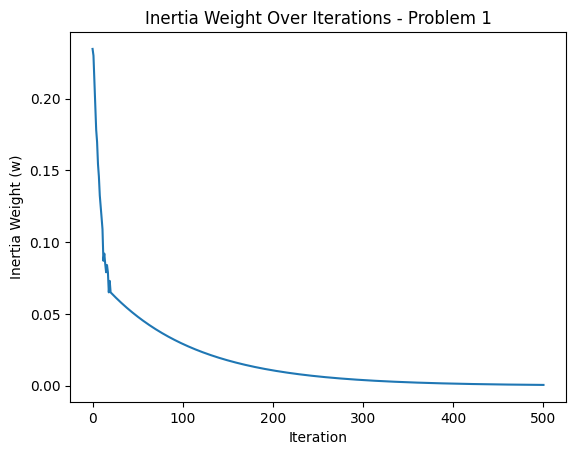

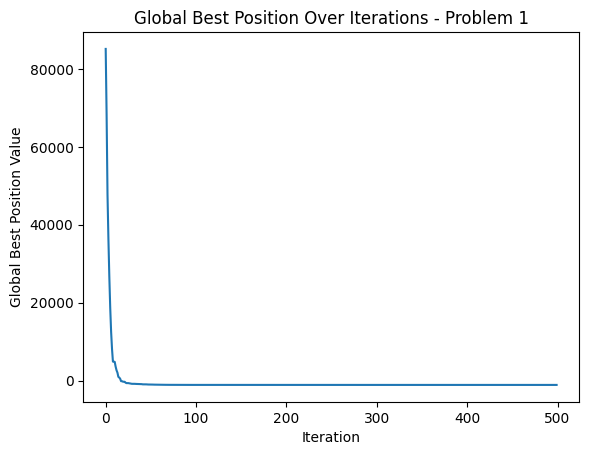




Problem 2 Best Cost: [-701.41269624 -701.43127847 -701.43747246 -701.47087549 -701.48553516
 -701.51463865 -701.54702703 -701.55452624 -701.57162265 -701.59429504
 -701.60169875 -701.60169875 -701.62221653 -701.65418495 -701.66459315
 -701.69233883 -701.6936554  -701.69725862 -701.69837733 -701.70530453
 -701.71080659 -701.7197486  -701.72303408 -701.74374742 -701.74647286
 -701.76224156 -701.77851422 -701.77851422 -701.77851422 -701.79277369
 -701.79277369 -701.79277369 -701.81324593 -701.81324593 -701.81324593
 -701.82304696 -701.82304696 -701.82405843 -701.82733424 -701.83517498
 -701.83517498 -701.83517498 -701.85265129 -701.85265129 -701.8602141
 -701.8602141  -701.8602141  -701.8602141  -701.8602141  -701.86099444
 -701.86282329 -701.87317449 -701.87317449 -701.87317449 -701.90034649
 -701.90034649 -701.90034649 -701.90034649 -701.90034649 -701.90034649
 -701.91435647 -701.91435647 -701.91659296 -701.92199746 -701.92653396
 -701.92653396 -701.92653396 -701.93932055 -701.939320

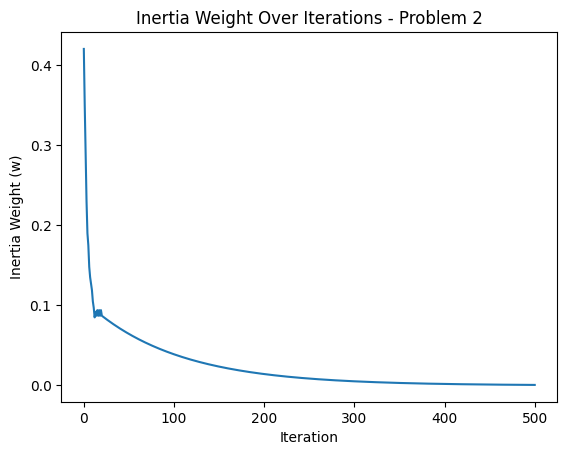

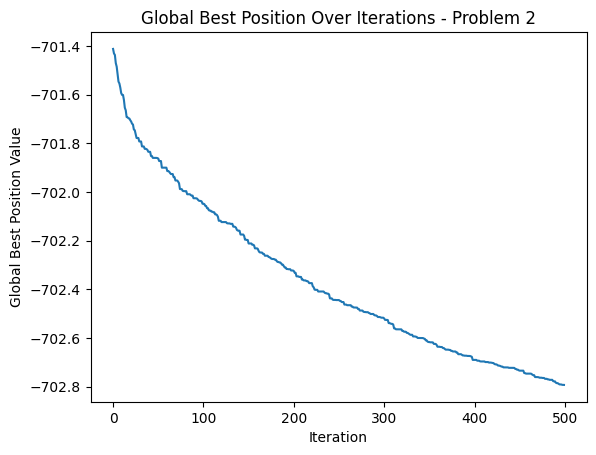




Problem 3 Best Cost: [ 3.68440981e+10  2.62594923e+10  2.12450603e+10  1.75509243e+10
  1.15489597e+10  8.28125584e+09  6.85096584e+09  5.36142552e+09
  4.26013216e+09  4.22348860e+09  3.03252373e+09  2.03180766e+09
  1.92836183e+09  1.80067350e+09  1.57768203e+09  1.28062308e+09
  1.28062308e+09  1.22869696e+09  6.73851267e+08  6.73851267e+08
  6.73851267e+08  6.73851267e+08  6.19472013e+08  4.44753639e+08
  4.23842063e+08  4.23842063e+08  4.18938565e+08  3.62099088e+08
  3.43692432e+08  3.43692432e+08  3.10332716e+08  2.69938250e+08
  2.69938250e+08  2.23737071e+08  1.76914838e+08  1.76914838e+08
  1.76914838e+08  1.76914838e+08  1.64549698e+08  1.48747971e+08
  1.26189789e+08  1.03024453e+08  1.03024453e+08  9.50564034e+07
  9.03532883e+07  5.32205776e+07  5.32205776e+07  5.32205776e+07
  4.94288615e+07  3.65263696e+07  2.99206040e+07  2.99206040e+07
  2.55721028e+07  2.55721028e+07  2.55721028e+07  2.55721028e+07
  2.55434657e+07  2.05204130e+07  1.80808274e+07  1.80808274e+07
 

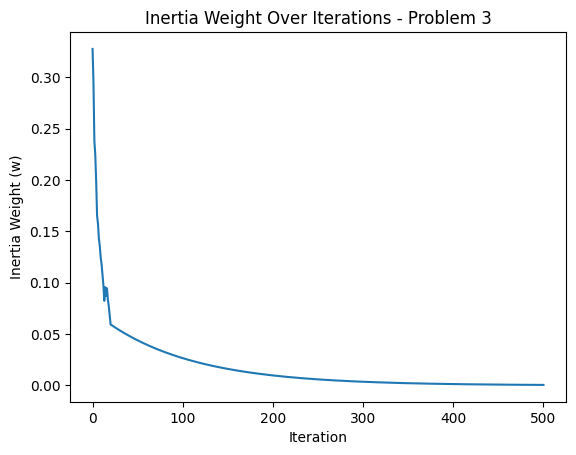

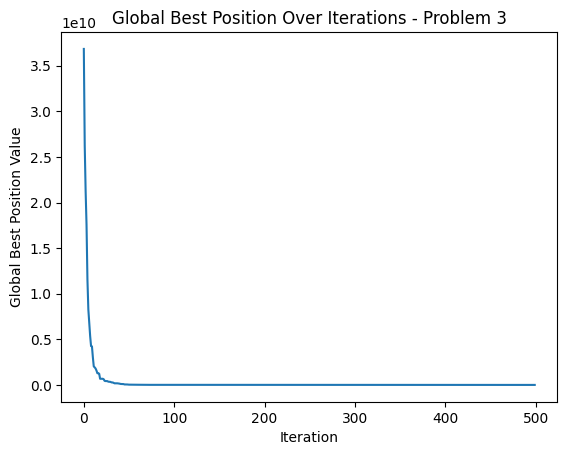




Problem 4 Best Cost: [ 3.84586388e+05  2.92753419e+05  2.06918511e+05  1.83620206e+05
  1.18714664e+05  6.76442891e+04  5.36195254e+04  4.74985095e+04
  4.52944916e+04  4.14400310e+04  3.40969449e+04  2.66808349e+04
  2.30413576e+04  2.30413576e+04  1.52637072e+04  1.28602045e+04
  1.07064355e+04  8.81480505e+03  8.75599684e+03  6.57867303e+03
  6.57867303e+03  6.57867303e+03  6.57867303e+03  5.10819220e+03
  4.73449454e+03  3.48754947e+03  3.48754947e+03  3.48754947e+03
  3.02199835e+03  2.47540618e+03  2.47540618e+03  2.40408283e+03
  1.53140066e+03  1.53140066e+03  1.36094757e+03  1.36094757e+03
  8.20496303e+02  5.35058638e+02  5.35058638e+02  5.35058638e+02
  5.35058638e+02  4.83991315e+02  4.83991315e+02  4.83991315e+02
  4.15456180e+02  4.15456180e+02  3.00597495e+02  2.68423654e+02
  1.89466030e+02  1.78867038e+02  1.78867038e+02  1.78867038e+02
  1.75345463e+02  1.72800311e+02  1.13734473e+01  1.13734473e+01
  1.13734473e+01  1.13734473e+01 -4.08311945e+01 -7.58478404e+01
 

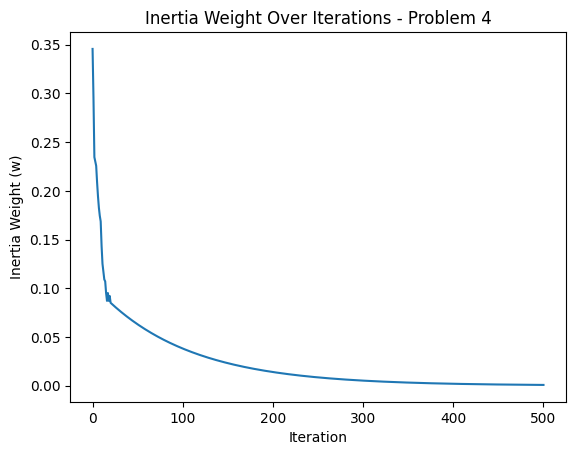

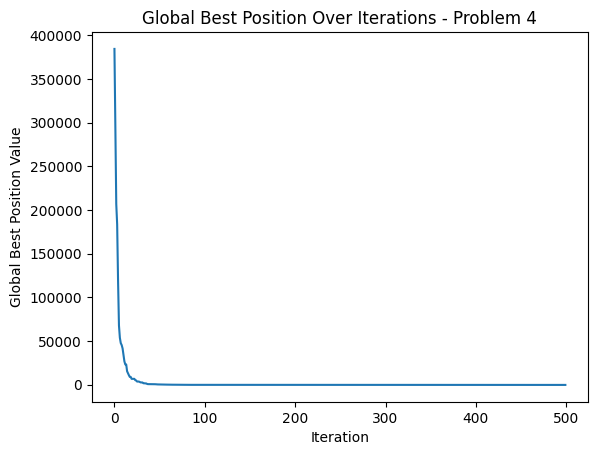




Problem 5 Best Cost: [-334.15564557 -334.22714286 -334.29446738 -334.3232874  -334.36688438
 -334.4748966  -334.49927073 -334.49927073 -334.56039122 -334.57781353
 -334.60833624 -334.60833624 -334.61470778 -334.67518617 -334.70205981
 -334.72815414 -334.73306183 -334.76039882 -334.76039882 -334.78604591
 -334.79136893 -334.80072936 -334.89429334 -334.89429334 -334.89429334
 -334.89429334 -334.9024361  -334.9024361  -334.95058887 -334.95279538
 -334.9644813  -334.97847632 -334.99946292 -334.99946292 -335.02622268
 -335.02887141 -335.03463574 -335.04374947 -335.05759198 -335.06184519
 -335.06538897 -335.06538897 -335.06538897 -335.06881407 -335.06881407
 -335.06881407 -335.10233346 -335.10233346 -335.10233346 -335.10928026
 -335.10928026 -335.1113178  -335.11391396 -335.12745153 -335.12745153
 -335.1370472  -335.16761954 -335.18967715 -335.18967715 -335.18967715
 -335.18968221 -335.18968221 -335.18968221 -335.18968221 -335.19760896
 -335.21261401 -335.21261401 -335.22914119 -335.22914

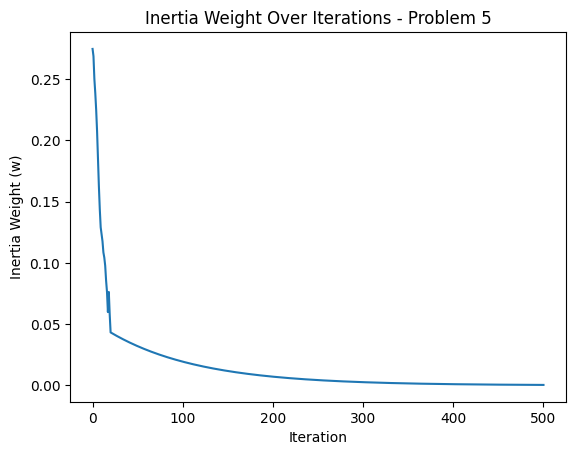

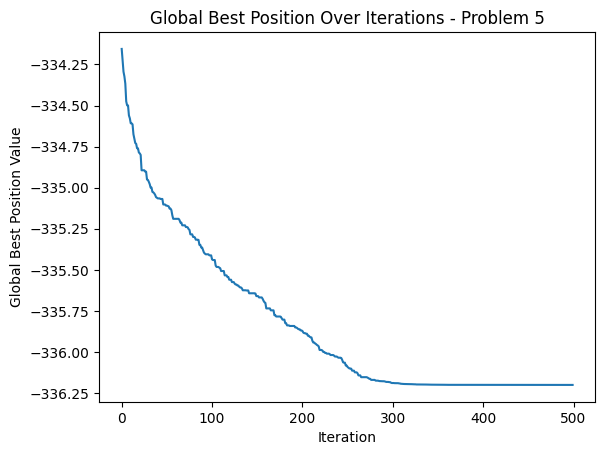




Problem 6 Best Cost: [-183.52688422 -183.61925991 -183.676884   -183.69352609 -183.73330049
 -183.80078468 -183.82051293 -183.90665587 -183.90855401 -183.9366601
 -183.9366601  -183.98360177 -184.02132922 -184.04904496 -184.05169475
 -184.06744324 -184.08054906 -184.08941836 -184.1053393  -184.12737571
 -184.12737571 -184.15879185 -184.15907482 -184.15907482 -184.18463646
 -184.18777711 -184.19825721 -184.22273906 -184.22273906 -184.23614468
 -184.23614468 -184.23614468 -184.24253252 -184.26500849 -184.27740488
 -184.27740488 -184.3090793  -184.3090793  -184.3090793  -184.3090793
 -184.3090793  -184.33873081 -184.33873081 -184.33973014 -184.33973014
 -184.35569752 -184.3859211  -184.3859211  -184.39304739 -184.39304739
 -184.39304739 -184.39304739 -184.40430669 -184.41348964 -184.42340473
 -184.4305097  -184.4305097  -184.43800492 -184.43800492 -184.46191229
 -184.46191229 -184.46410162 -184.46410162 -184.46410162 -184.46410162
 -184.47102501 -184.47827803 -184.47827803 -184.4782780

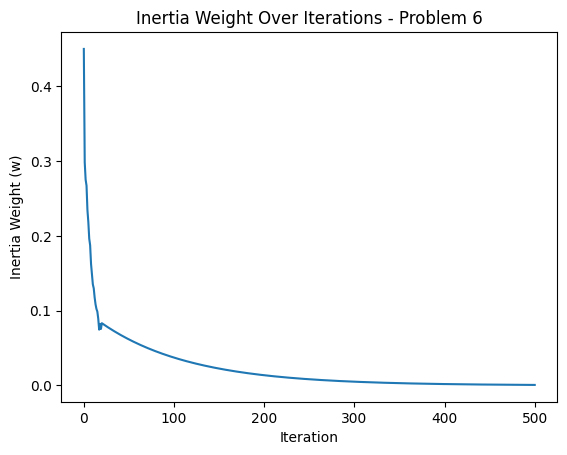

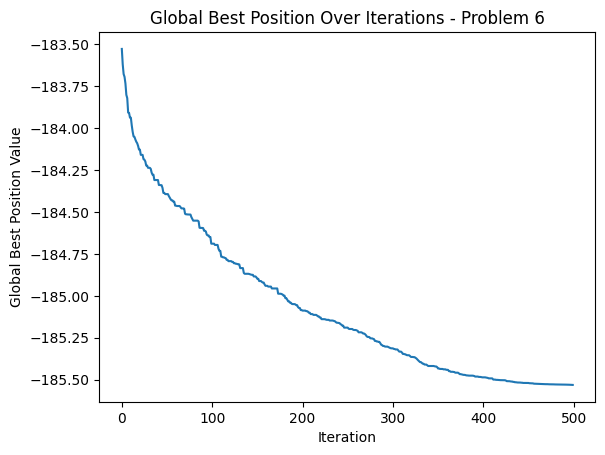




Problem 7 Best Cost: [ 7.56053865e+04  5.50998672e+04  4.44781477e+04  3.83986120e+04
  2.72514574e+04  2.72514574e+04  2.40015418e+04  2.40015418e+04
  2.40015418e+04  2.06310592e+04  1.79042105e+04  1.41357218e+04
  1.19269319e+04  9.27758607e+03  6.91819706e+03  6.03497384e+03
  6.03497384e+03  6.03497384e+03  6.03497384e+03  6.03497384e+03
  5.60371439e+03  4.77519052e+03  4.77519052e+03  3.39931475e+03
  3.14481808e+03  3.14481808e+03  3.14481808e+03  3.14481808e+03
  2.79423320e+03  2.46408028e+03  2.29944493e+03  2.24423466e+03
  1.88214978e+03  1.64457585e+03  1.64457585e+03  1.64457585e+03
  1.64457585e+03  1.60248235e+03  1.46529841e+03  1.31942764e+03
  1.31942764e+03  1.31942764e+03  1.09555541e+03  1.03710872e+03
  7.91685604e+02  7.91685604e+02  3.27547289e+02  3.27547289e+02
  3.12328679e+02  2.63999286e+02  2.63999286e+02 -3.72282864e+01
 -1.37348356e+02 -4.04171198e+02 -4.04171198e+02 -4.04171198e+02
 -4.04171198e+02 -4.04171198e+02 -4.04171198e+02 -4.04171198e+02
 

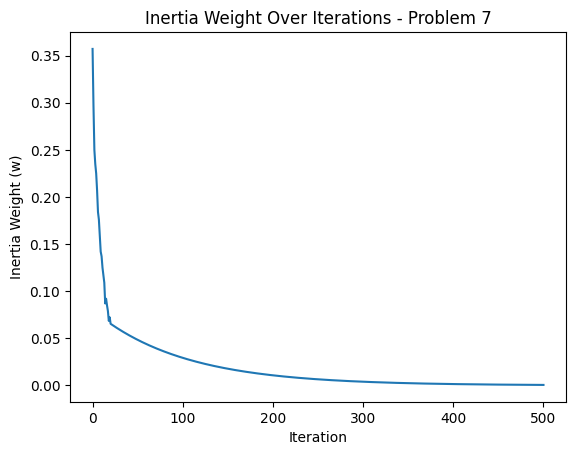

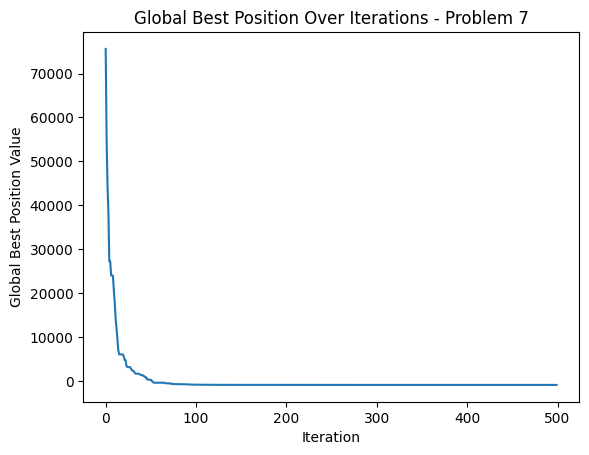




Problem 8 Best Cost: [ 5.30466056e+04  4.10441491e+04  3.45681032e+04  2.81923651e+04
  2.07077876e+04  1.84572631e+04  1.48245599e+04  1.17410375e+04
  1.17410375e+04  1.17410375e+04  1.17410375e+04  1.17410375e+04
  1.17410375e+04  1.17410375e+04  1.17410375e+04  1.17410375e+04
  1.16792267e+04  9.61853376e+03  8.80439634e+03  8.80439634e+03
  8.80439634e+03  8.80439634e+03  8.80439634e+03  8.80439634e+03
  8.80439634e+03  8.80439634e+03  8.80439634e+03  7.79844597e+03
  6.75743127e+03  4.62051022e+03  4.62051022e+03  4.49487705e+03
  4.49487705e+03  4.49487705e+03  3.38496474e+03  1.77212619e+03
  1.43393053e+03  1.08290315e+03  1.03545782e+03  1.03545782e+03
  1.03545782e+03  5.71752360e+02  5.71752360e+02  5.71752360e+02
  4.34356920e+02  2.90524774e+02  2.90524774e+02  1.30300096e+02
  2.52187501e+01  2.52187501e+01  2.52187501e+01 -7.70571909e+01
 -7.70571909e+01 -7.70571909e+01 -7.70571909e+01 -3.31954200e+02
 -3.31954200e+02 -3.31954200e+02 -3.31954200e+02 -3.31954200e+02
 

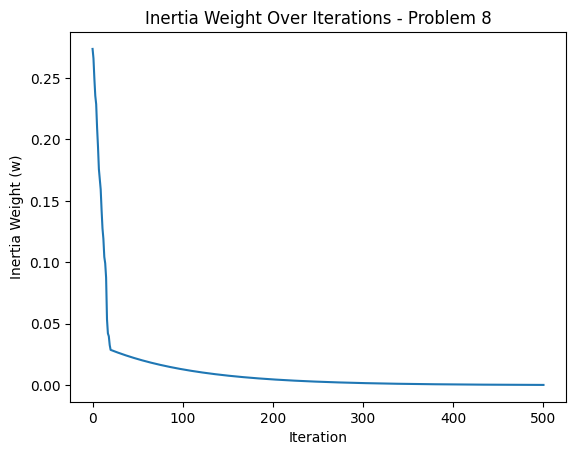

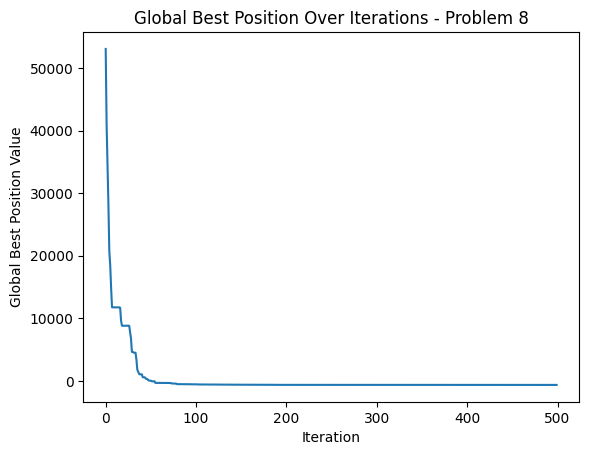




Problem 9 Best Cost: [137451.14115296 137305.67630437 137305.67630437 137305.67630437
 137305.67630437 137305.67630437 119844.98268096 119844.98268096
 119844.98268096 119844.98268096 103793.4654442  103793.4654442
 103793.4654442  103793.4654442  103793.4654442  103793.4654442
  89268.28001244  89268.28001244  89268.28001244  70457.70835004
  70457.70835004  70457.70835004  70457.70835004  70457.70835004
  70457.70835004  70457.70835004  70457.70835004  70457.70835004
  24235.13507847  24235.13507847  24235.13507847  24235.13507847
  24235.13507847  24235.13507847  14662.04685158  14662.04685158
  14662.04685158  14662.04685158  14662.04685158  14662.04685158
  14662.04685158  14662.04685158  14662.04685158  14662.04685158
  14357.38701955  14357.38701955  14357.38701955  14357.38701955
  14357.38701955  14357.38701955  14357.38701955  14357.38701955
  14357.38701955  10252.16525396  10252.16525396   9789.47310783
   9745.26952182   9745.26952182   9745.26952182   9745.26952182
   

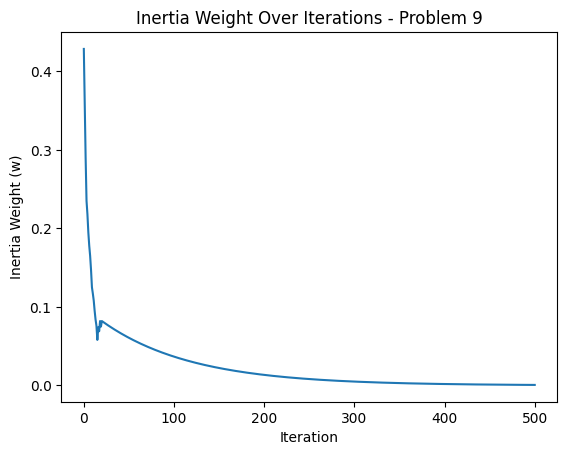

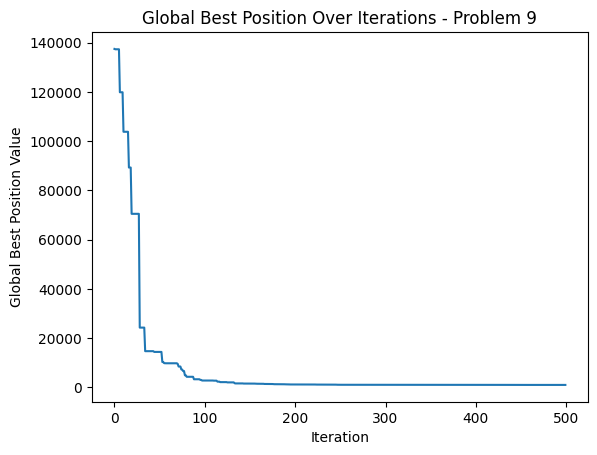




Problem 10 Best Cost: [58048.9344906  36276.6357061  16196.2930016  16196.2930016
 16196.2930016  16196.2930016  16196.2930016  16196.2930016
 16196.2930016  16196.2930016  16196.2930016  16196.2930016
 16196.2930016  16196.2930016  16196.2930016  16026.08177371
 16026.08177371 15515.94923497 15515.94923497 15515.94923497
 14843.43093621 14843.43093621 14843.43093621 13197.54895652
 13197.54895652 13197.54895652 13197.54895652 13197.54895652
 13197.54895652 13197.54895652 13197.54895652 12886.75231007
 12886.75231007 12886.75231007 12886.75231007 12886.75231007
 12886.75231007 12886.75231007 11925.32541576 11434.95086169
 11400.52599757 11400.52599757 10918.90721155 10918.90721155
 10327.05860613 10327.05860613 10327.05860613 10207.37807873
 10207.37807873 10207.37807873  9522.66974383  9522.66974383
  9522.66974383  9474.07280843  9474.07280843  9474.07280843
  9474.07280843  9474.07280843  9474.07280843  9268.49521927
  9268.49521927  9233.81884901  8670.73550549  8670.73550549
  

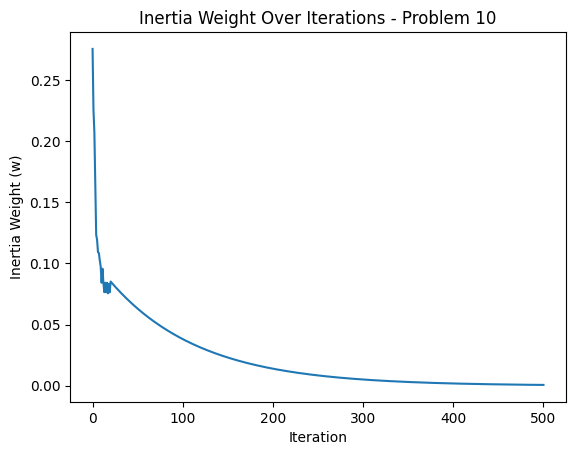

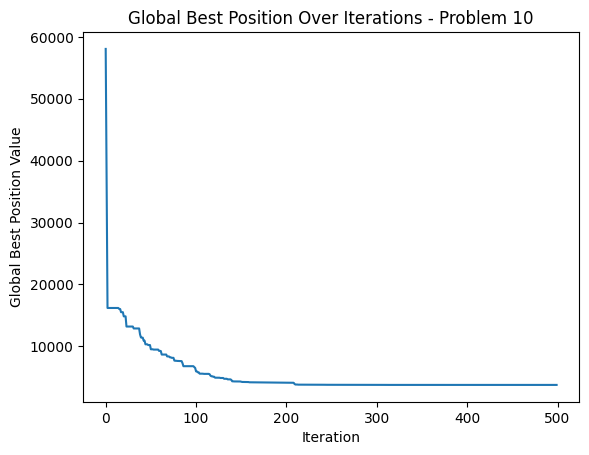




Problem 11 Best Cost: [74738.27951099 56115.23982627 46862.28057695 39160.97016692
 24811.99008037 22738.28681599 22738.28681599 22738.28681599
 22738.28681599 22738.28681599 22738.28681599 21666.9194933
 21666.9194933  18866.56565361 18866.56565361 18298.65083073
 15972.5266479  13921.44753029  9310.84374137  8889.66481985
  8889.66481985  8889.66481985  8677.24413802  8351.85616873
  8185.46258247  8185.46258247  8185.46258247  8185.46258247
  7702.81614911  7341.39580611  7341.39580611  7341.39580611
  7341.39580611  7341.39580611  5828.44988868  5828.44988868
  5828.44988868  5828.44988868  5828.44988868  5828.44988868
  5822.37759099  5822.37759099  5822.37759099  5822.37759099
  5822.37759099  5822.37759099  5822.37759099  5822.37759099
  5651.26631954  5651.26631954  5651.26631954  5651.26631954
  5651.26631954  5651.26631954  5651.26631954  5555.12070853
  5036.52132341  4656.46812241  4279.3879835   4188.93145115
  4188.93145115  3937.46321086  3937.46321086  3937.46321086


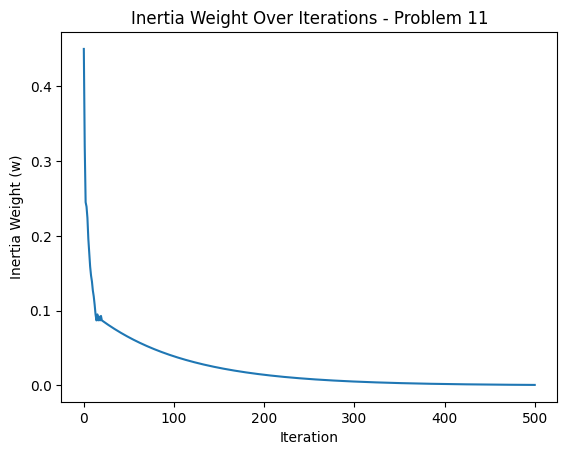

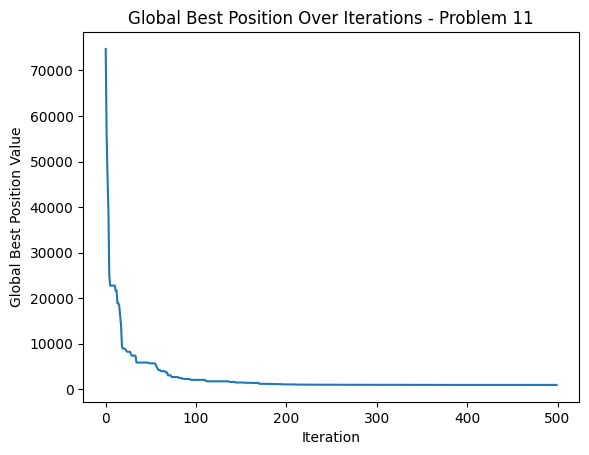




Problem 12 Best Cost: [78085.37795941 46690.22843041 46690.22843041 46690.22843041
 46690.22843041 46690.22843041 46690.22843041 46690.22843041
 46690.22843041 45870.47111753 45870.47111753 39660.80055411
 39660.80055411 35434.11926635 35434.11926635 35434.11926635
 35434.11926635 35434.11926635 33577.28255244 33577.28255244
 33577.28255244 33577.28255244 32675.7872126  32675.7872126
 32675.7872126  32675.7872126  31938.74228907 31938.74228907
 31938.74228907 31938.74228907 31938.74228907 31938.74228907
 31938.74228907 31938.74228907 31938.74228907 31938.74228907
 31938.74228907 30983.22836733 30983.22836733 30880.71168617
 30880.71168617 30880.71168617 30050.72759722 30050.72759722
 30050.72759722 30050.72759722 30050.72759722 30050.72759722
 28606.69786261 28606.69786261 28025.89832938 28025.89832938
 28025.89832938 28025.89832938 27658.80132874 27658.80132874
 26733.75575891 26733.75575891 26733.75575891 26733.75575891
 26733.75575891 26733.75575891 26435.9458512  26435.9458512
 

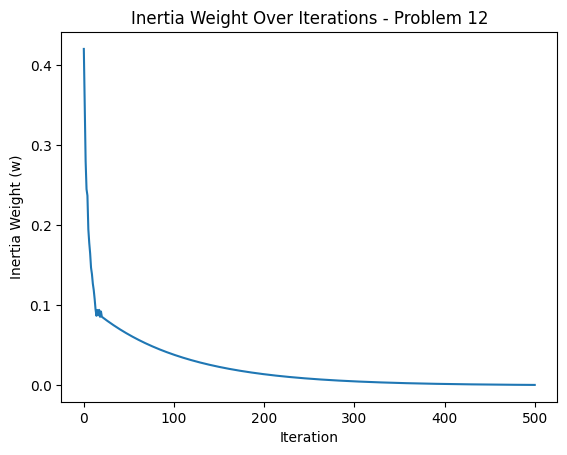

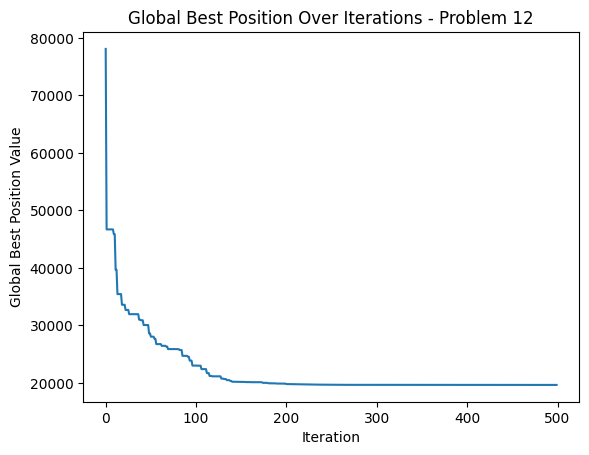




Problem 13 Best Cost: [197097.88185848 197097.88185848 168697.75478381  96744.02778895
  96744.02778895  96744.02778895  96744.02778895  96744.02778895
  96744.02778895  96744.02778895  96744.02778895  96744.02778895
  96744.02778895  96744.02778895  96744.02778895  93842.41055557
  93842.41055557  93842.41055557  93842.41055557  93842.41055557
  93842.41055557  93842.41055557  93842.41055557  76849.55931134
  76849.55931134  76849.55931134  76849.55931134  38060.64551564
  38060.64551564  38060.64551564  38060.64551564  38060.64551564
  38060.64551564  38060.64551564  38060.64551564  38060.64551564
  38060.64551564  38060.64551564  38060.64551564  38060.64551564
  38060.64551564  38060.64551564  38060.64551564  38060.64551564
  38060.64551564  38060.64551564  38060.64551564  38060.64551564
  38060.64551564  38060.64551564  38060.64551564  38060.64551564
  38060.64551564  38060.64551564  38060.64551564  38060.64551564
  38060.64551564  38060.64551564  38060.64551564  38060.64551564


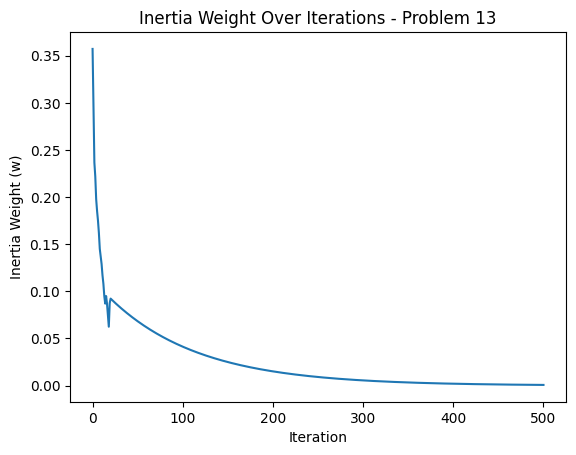

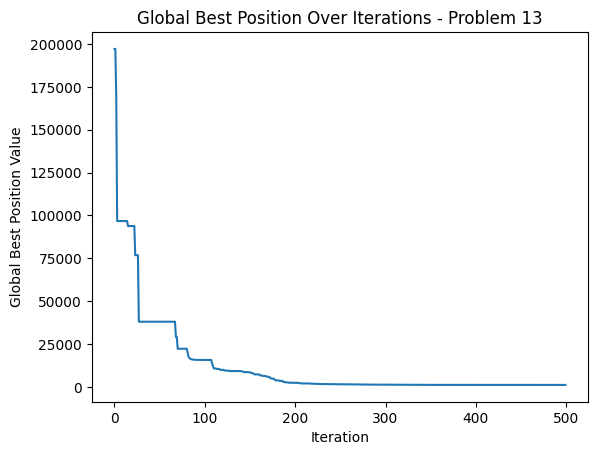




Problem 14 Best Cost: [26930.20375167 26930.20375167 22470.9326443  22470.9326443
 22470.9326443  18272.9050314  18272.9050314  18195.83916231
 16796.49030096 16796.49030096 15400.60960455 15400.60960455
 15400.60960455 15400.60960455 14886.93819396 14886.93819396
 14886.93819396 14886.93819396 14886.93819396 14886.93819396
 14693.17535049 14693.17535049 14693.17535049 14323.22697061
 14323.22697061 14323.22697061 14323.22697061 14323.22697061
 14323.22697061 14323.22697061 14323.22697061 13447.97248099
 13003.87687826 13003.87687826 13003.87687826 13003.87687826
 13003.87687826 13003.87687826 13003.87687826 13003.87687826
 13003.87687826 13003.87687826 12938.69326256 12938.69326256
 12327.39984045 12327.39984045 12327.39984045 12327.39984045
 12327.39984045 12327.39984045 12240.4816679  12122.96294139
 12122.96294139 12057.83643907 11378.64729894 11056.59910915
 11056.59910915 11056.59910915 11056.59910915 11056.59910915
 11056.59910915 11056.59910915 11056.59910915 11056.59910915


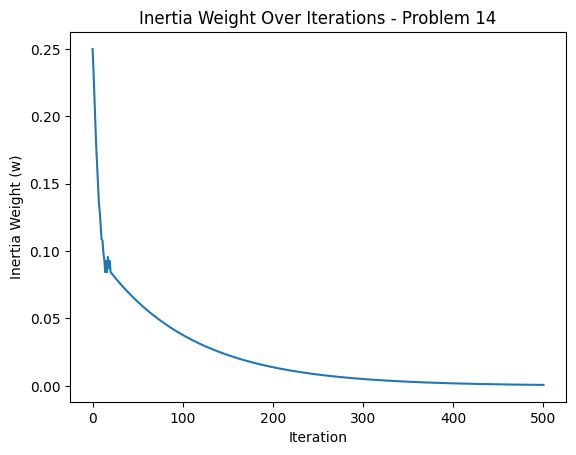

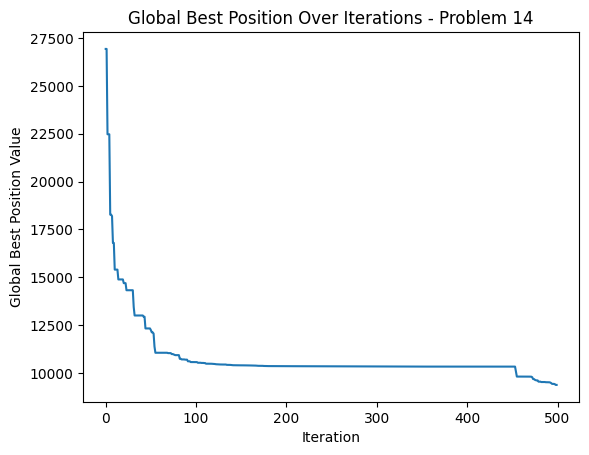




Problem 15 Best Cost: [-224.72639748 -225.28275601 -225.28275601 -225.28275601 -225.28275601
 -225.28275601 -225.28275601 -225.28275601 -225.46867425 -225.8378712
 -226.43365438 -226.43365438 -226.43365438 -226.77247408 -226.77247408
 -226.77247408 -226.77247408 -226.77247408 -226.77247408 -226.77247408
 -227.0283956  -227.0283956  -227.0283956  -227.0283956  -227.18056617
 -227.18056617 -227.362527   -227.362527   -227.362527   -227.362527
 -227.362527   -227.362527   -227.362527   -227.43996362 -227.43996362
 -227.43996362 -227.46293695 -227.50768442 -227.50768442 -227.52609683
 -227.65763072 -227.65763072 -227.65763072 -227.7220156  -227.79443532
 -227.81464434 -227.81464434 -227.81464434 -227.81464434 -227.81464434
 -227.82602873 -227.82602873 -227.83089719 -227.84159496 -227.84159496
 -227.8582547  -227.8582547  -227.8582547  -227.8582547  -227.87496286
 -227.87496286 -227.87496286 -227.87844318 -227.87844318 -227.88940518
 -227.90056667 -227.90056667 -227.90056667 -227.9005666

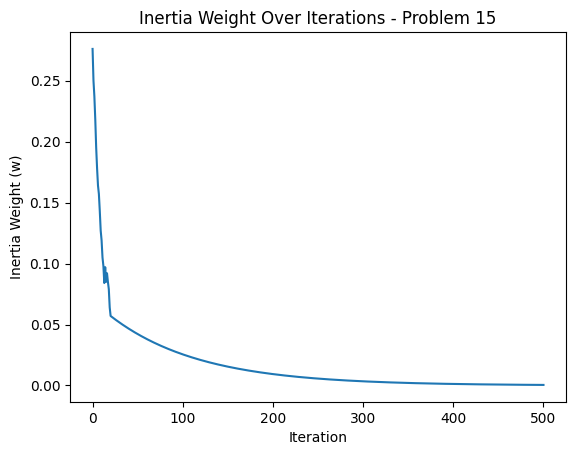

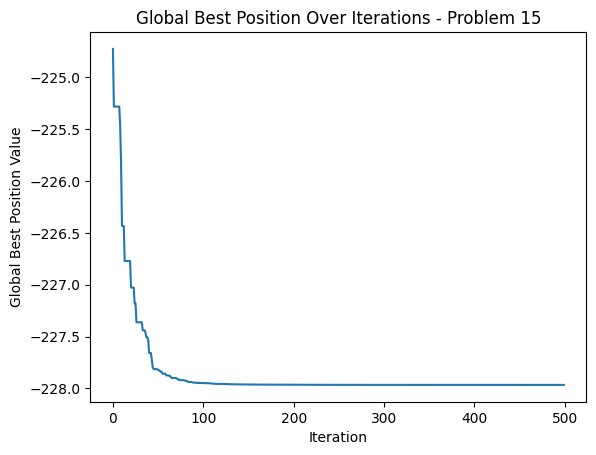




Problem 16 Best Cost: [56002.0654988  38561.15697034 31335.21631982 28808.21544953
 21055.89005674 16094.73101127  7526.14606473  5820.24592118
  2825.33552174  2825.33552174  1446.96464851   242.30982418
  -218.17321525 -1047.06175929 -1509.04640789 -1509.04640789
 -1786.07509497 -2258.51235132 -2460.41289527 -2902.9930737
 -3007.49814984 -3170.34653604 -3559.68055289 -3559.68055289
 -3559.68055289 -3599.30286582 -3753.87319027 -3799.83385509
 -3799.83385509 -3932.95685424 -3961.83161386 -3961.83161386
 -4006.86517687 -4006.86517687 -4006.86517687 -4006.86517687
 -4058.1378826  -4079.23450776 -4132.14931271 -4132.14931271
 -4132.14931271 -4132.14931271 -4196.59965138 -4196.59965138
 -4198.48976918 -4216.31787468 -4230.59281214 -4230.59281214
 -4230.59281214 -4247.87274175 -4248.68606577 -4256.24834696
 -4256.24834696 -4256.24834696 -4257.55218525 -4257.55218525
 -4271.05254949 -4271.05254949 -4271.05254949 -4273.67030665
 -4273.67030665 -4275.03102548 -4278.50050698 -4278.50050698


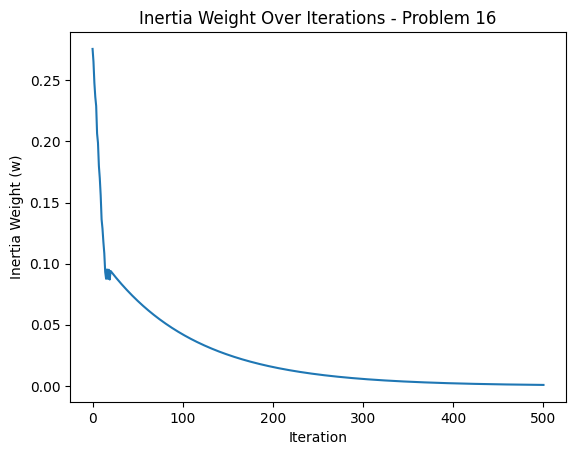

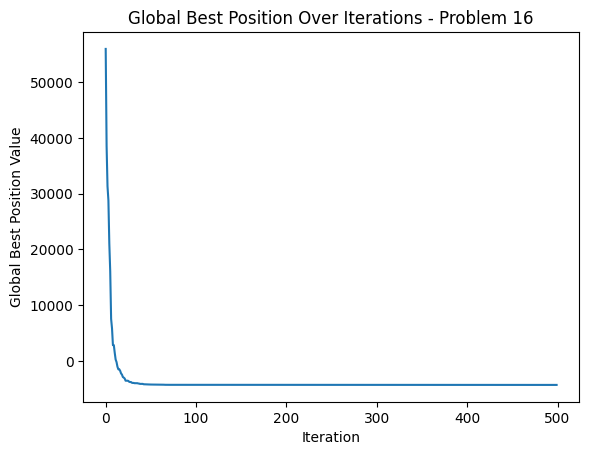




Problem 17 Best Cost: [ 3.27872445e+06  2.18781685e+06  1.62922748e+06  1.40554948e+06
  1.04086730e+06  8.84792434e+05  6.26559637e+05  5.12343408e+05
  4.41545366e+05  3.82125459e+05  2.80548865e+05  2.79530498e+05
  2.48114846e+05  1.92858287e+05  1.61732660e+05  1.61732660e+05
  1.54172875e+05  8.43592628e+04  8.43592628e+04  8.43592628e+04
  6.69883339e+04  6.69883339e+04  6.11437752e+04  5.86164672e+04
  5.86164672e+04  5.06546230e+04  5.06546230e+04  4.81926493e+04
  4.64522351e+04  4.00299530e+04  3.86981341e+04  3.50444335e+04
  3.01251022e+04  3.01251022e+04  2.65277487e+04  2.27954065e+04
  2.27954065e+04  2.17119458e+04  2.11209821e+04  1.82298356e+04
  1.82298356e+04  1.51656551e+04  1.51656551e+04  1.45715344e+04
  1.44494584e+04  1.36699495e+04  1.32595474e+04  1.32595474e+04
  1.22135997e+04  1.06626845e+04  1.06626845e+04  8.69684628e+03
  8.61386118e+03  8.42886337e+03  8.22073522e+03  8.22073522e+03
  6.04110040e+03  6.04110040e+03  5.78344016e+03  5.78344016e+03


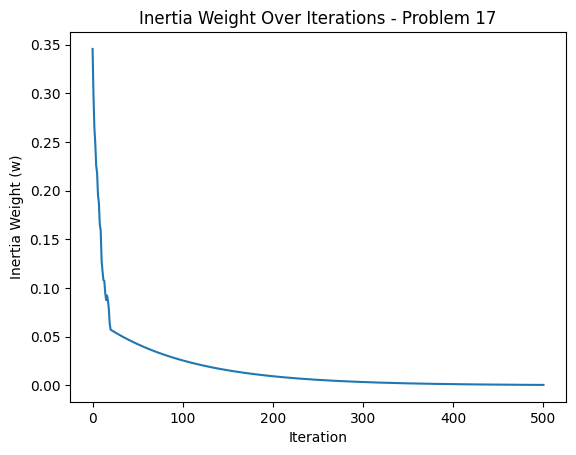

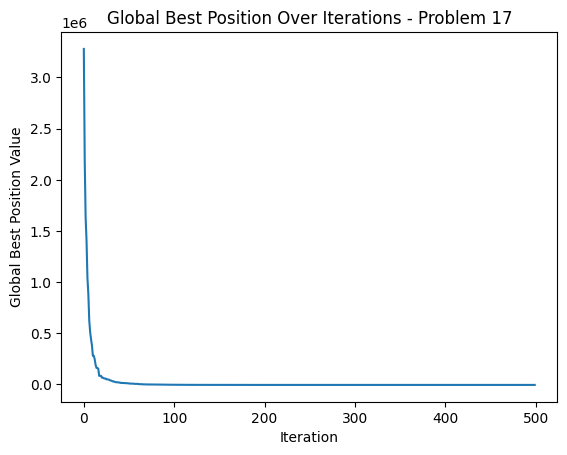




Problem 18 Best Cost: [58162.47979524 41144.50370522 41144.50370522 36006.88779184
 26343.3783305  26343.3783305  26343.3783305  26343.3783305
 26343.3783305  26343.3783305  26343.3783305  26343.3783305
 26343.3783305  26343.3783305  26343.3783305  26343.3783305
 26343.3783305  26343.3783305  26343.3783305  26343.3783305
 20209.32918537 20209.32918537 20209.32918537 20209.32918537
 20209.32918537 20209.32918537 20209.32918537 20209.32918537
 20209.32918537 20209.32918537 19208.94615871 19208.94615871
 19208.94615871 19208.94615871 19208.94615871 19039.58071862
 19039.58071862 18413.15445513 18413.15445513 18413.15445513
 18325.46907028 15767.74676827 15767.74676827 15767.74676827
 15767.74676827 15767.74676827 15767.74676827 15767.74676827
 15767.74676827 15767.74676827 14348.36633395 14348.36633395
 14348.36633395 14348.36633395 14348.36633395 14348.36633395
 12185.22409844 12185.22409844 12185.22409844 12185.22409844
 12185.22409844 12185.22409844 12185.22409844 12185.22409844
 12

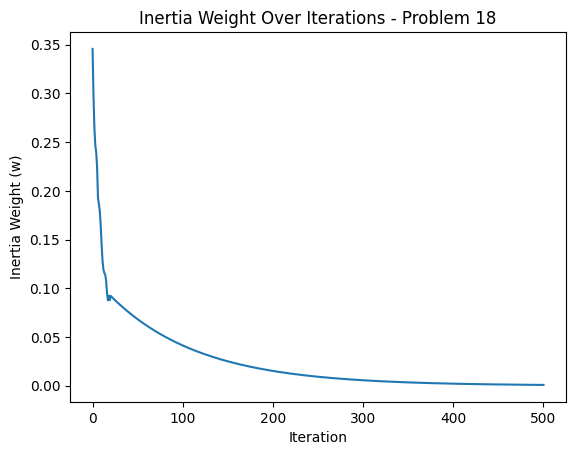

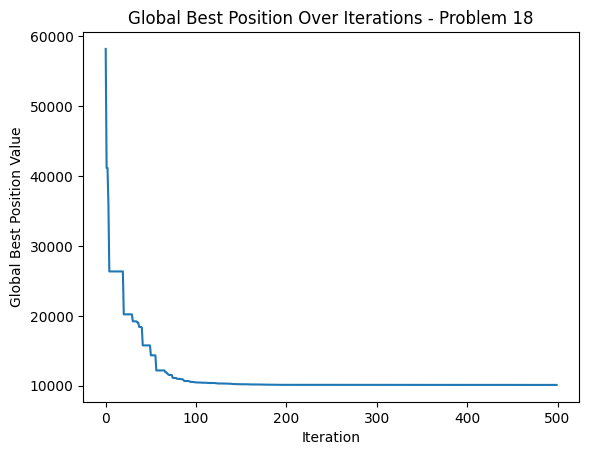




Problem 19 Best Cost: [36190.73845614 36190.73845614 36190.73845614 36190.73845614
 36190.73845614 36190.73845614 36190.73845614 36190.73845614
 36190.73845614 36190.73845614 34473.88498861 34473.88498861
 34473.88498861 34473.88498861 34473.88498861 34473.88498861
 34473.88498861 34473.88498861 34473.88498861 34473.88498861
 34473.88498861 34473.88498861 34473.88498861 34473.88498861
 34473.88498861 34473.88498861 34473.88498861 34473.88498861
 34473.88498861 33596.17097179 33596.17097179 33596.17097179
 33596.17097179 33535.5333282  25774.55759045 22344.40241805
 22344.40241805 19511.86922142 19511.86922142 19511.86922142
 18488.87161748 18488.87161748 18488.87161748 18488.87161748
 18488.87161748 18488.87161748 18488.87161748 18488.87161748
 18488.87161748 18488.87161748 18488.87161748 18488.87161748
 18488.87161748 18488.87161748 18488.87161748 18488.87161748
 18488.87161748 18488.87161748 18488.87161748 18488.87161748
 18488.87161748 18488.87161748 18488.87161748 18488.87161748

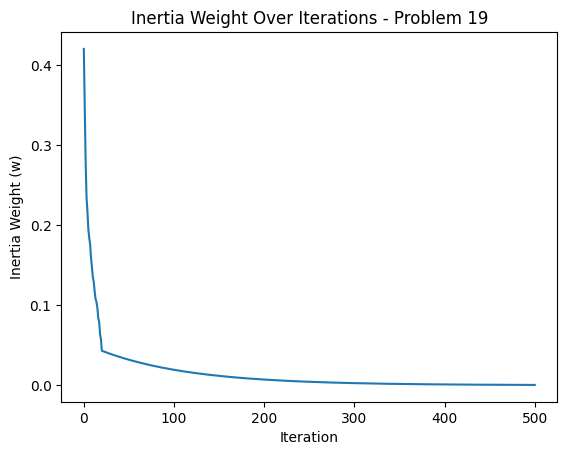

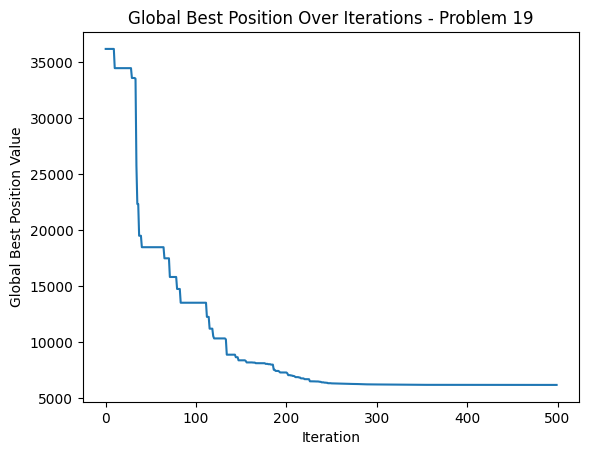




Problem 20 Best Cost: [-82.31377039 -83.83231194 -84.52845971 -84.52845971 -84.63247046
 -84.63247046 -84.63247046 -84.91861568 -84.99884405 -84.99884405
 -85.32613247 -85.56342637 -86.15192907 -86.15192907 -86.15192907
 -86.15192907 -86.15192907 -86.15192907 -86.15192907 -86.15192907
 -86.15192907 -86.15192907 -86.15192907 -86.15192907 -86.15192907
 -86.328679   -86.328679   -86.43226562 -86.43226562 -86.56514495
 -86.56514495 -86.56514495 -86.56514495 -86.56514495 -86.56514495
 -86.56514495 -86.56514495 -86.56514495 -86.56514495 -86.59558253
 -86.59558253 -86.59558253 -86.59558253 -86.60775757 -86.73606826
 -86.73606826 -86.75438134 -86.75859469 -86.75859469 -86.75859469
 -86.80872321 -86.80872321 -86.80872321 -86.8156366  -86.86992787
 -86.93686915 -86.93686915 -86.93686915 -86.93686915 -86.93686915
 -86.94450639 -86.94450639 -86.94450639 -86.94450639 -86.95198909
 -86.95198909 -86.95198909 -86.95198909 -87.00225745 -87.02310485
 -87.03383725 -87.03383725 -87.03383725 -87.0338372

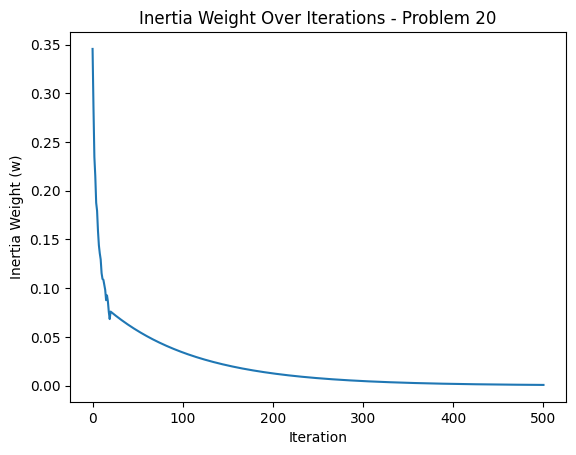

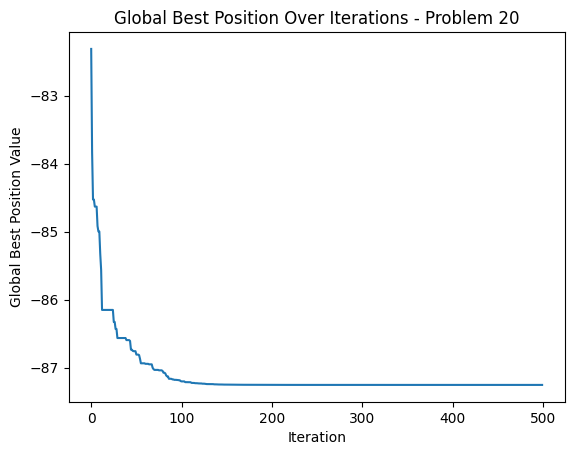




Problem 21 Best Cost: [165.96875123 102.30125566  58.10585305  25.88541972  12.5718885
  12.5718885    7.7949772    7.7949772    6.96284127  -6.55620331
  -6.55620331 -10.41882755 -10.41882755 -10.41882755 -10.41882755
 -11.26217696 -12.2411337  -15.23727851 -15.23727851 -16.88155036
 -16.88155036 -16.88155036 -16.88155036 -16.88155036 -16.88155036
 -19.76957059 -19.76957059 -19.76957059 -19.76957059 -20.11168372
 -20.49802881 -22.47271379 -22.47271379 -22.47271379 -23.15147821
 -25.04781994 -25.66676594 -25.66676594 -26.91104801 -26.91104801
 -26.91104801 -26.91104801 -27.32851032 -27.32851032 -27.68003063
 -29.69430694 -29.69430694 -29.69430694 -29.69430694 -29.69430694
 -29.73282886 -29.73282886 -29.73282886 -29.73282886 -30.23471764
 -30.23471764 -31.52505116 -31.52505116 -31.52505116 -31.52505116
 -32.87668641 -33.43012012 -34.18248825 -34.35786051 -35.34673917
 -35.34673917 -35.34673917 -36.27355003 -36.27355003 -36.27355003
 -36.27355003 -36.27355003 -36.27355003 -36.40652859

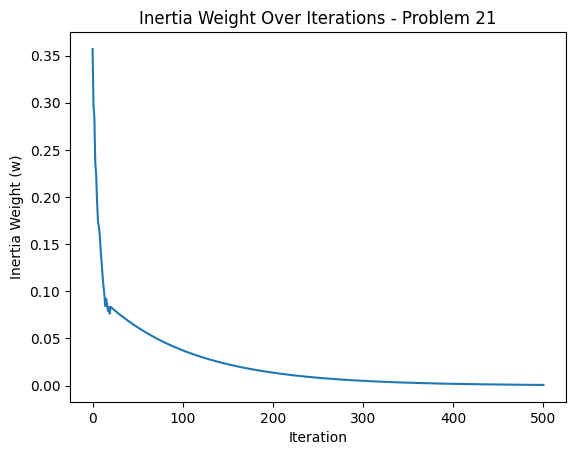

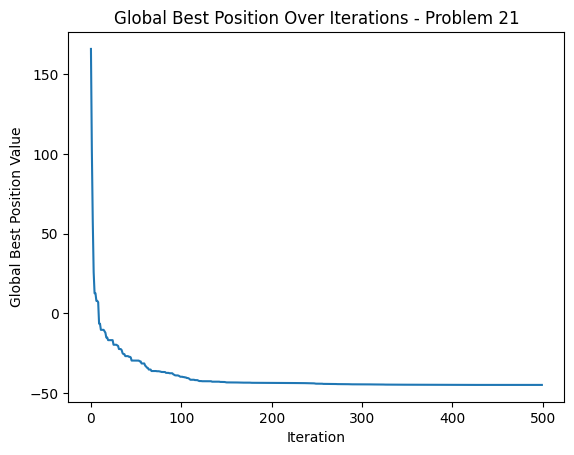




Problem 22 Best Cost: [207267.83825764 196790.15700841 196790.15700841 196790.15700841
 196790.15700841 196790.15700841 166870.66726725 166870.66726725
 166870.66726725 166870.66726725 166870.66726725 166870.66726725
 166870.66726725 166870.66726725 166870.66726725 166870.66726725
 166870.66726725 166870.66726725 157354.51539515 146367.88909173
 146367.88909173 146367.88909173 146367.88909173 146367.88909173
 146367.88909173 131685.24670443 131685.24670443 124939.03520678
 124939.03520678 124939.03520678 124939.03520678 124939.03520678
 124939.03520678 124656.61825058 120640.12535315 116836.0057079
 116836.0057079  108639.96277018 108639.96277018 108639.96277018
 108639.96277018 108639.96277018 108621.43198492 108621.43198492
 108621.43198492 108105.36261207 108105.36261207 107589.20759572
 106456.2843593  106456.2843593  106456.2843593  105878.58187627
 105712.60865541 105712.60865541 105712.60865541 105636.94945716
 105636.94945716 105636.94945716 105636.94945716 105568.49214067
 

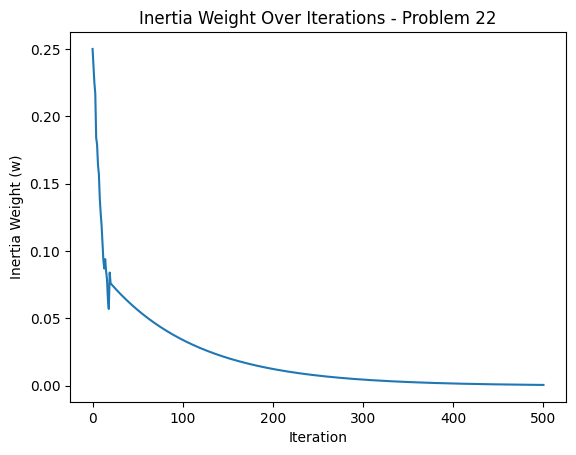

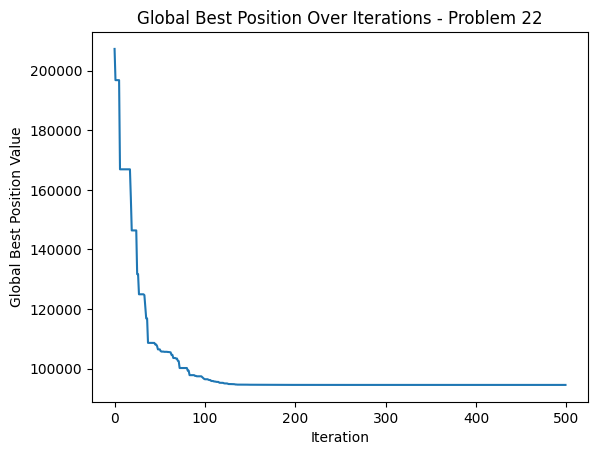




Problem 23 Best Cost: [-19.90443699 -23.00804469 -32.97180419 -35.6327473  -47.03135372
 -51.15053089 -51.15053089 -51.15053089 -51.15053089 -51.15053089
 -51.15053089 -53.54608217 -53.54608217 -53.54608217 -54.98336431
 -58.53284353 -58.53284353 -60.10604102 -60.10604102 -60.10604102
 -60.10604102 -60.10604102 -60.10604102 -60.10604102 -60.10604102
 -60.10604102 -60.10604102 -61.78446229 -61.78446229 -61.78446229
 -61.78446229 -61.78446229 -61.78446229 -61.78446229 -61.78446229
 -61.98981391 -61.98981391 -63.10875447 -63.10875447 -63.10875447
 -63.10875447 -63.10875447 -63.10875447 -63.10875447 -63.48775715
 -63.48775715 -64.47118195 -64.47118195 -65.41572238 -65.41572238
 -65.41572238 -65.41572238 -65.41572238 -65.41572238 -65.64617395
 -65.64617395 -65.64617395 -65.64617395 -65.64617395 -65.72164521
 -65.72164521 -65.72164521 -65.72164521 -65.72164521 -65.72164521
 -65.88516573 -66.04391708 -66.04391708 -66.06490025 -66.29537582
 -66.35007469 -66.35007469 -66.35007469 -66.3594369

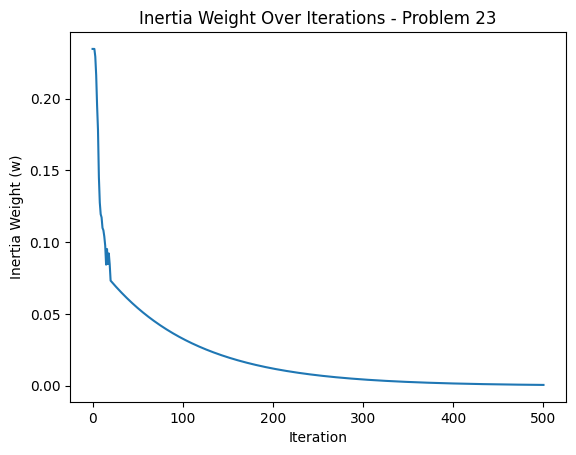

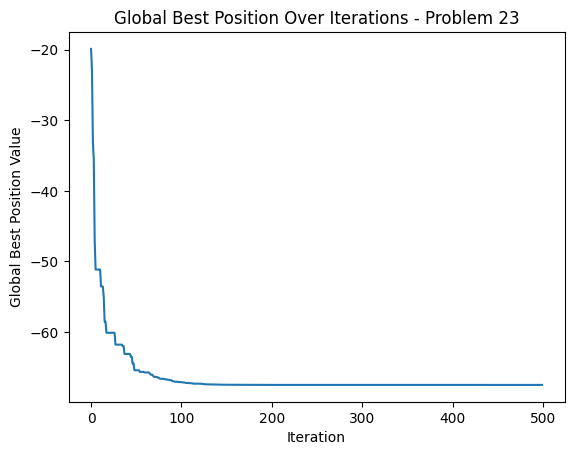




Problem 24 Best Cost: [121.79167444 109.52729468 102.19199884  95.31010038  93.21744501
  83.24853779  68.27067912  65.26124929  60.5810316   60.5810316
  60.5810316   53.19223634  53.19223634  46.95219913  46.95219913
  42.53216866  42.53216866  42.53216866  42.53216866  41.19517908
  41.19517908  40.70382048  40.70382048  40.44284848  40.44284848
  40.44284848  40.44284848  40.44284848  40.44284848  40.44284848
  38.90240587  38.90240587  38.90240587  38.90240587  38.90240587
  38.90240587  38.90240587  38.90240587  38.27550865  38.27550865
  38.27550865  38.27550865  38.27550865  38.27550865  38.27550865
  38.27550865  34.63676254  34.63676254  34.63676254  34.63676254
  34.63676254  34.63676254  34.3057561   33.60240392  33.60240392
  30.76460935  30.76460935  30.76460935  30.76460935  30.68465758
  30.68465758  30.68465758  30.68465758  26.82075433  26.82075433
  26.82075433  26.82075433  26.82075433  26.82075433  24.23037677
  24.23037677  24.23037677  24.23037677  24.23037677

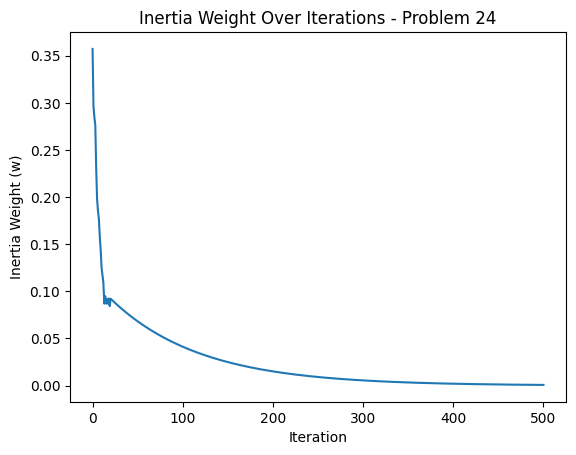

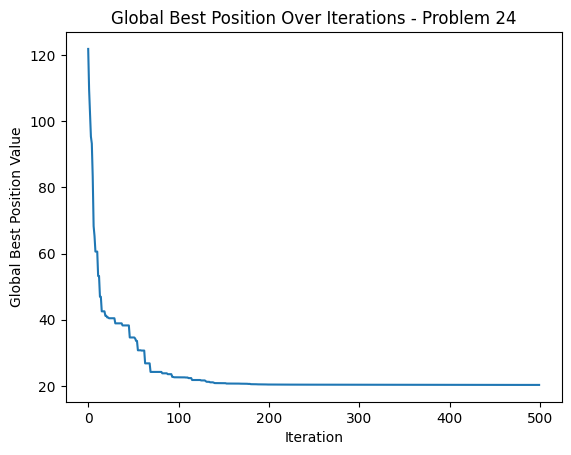

In [22]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()

In [23]:
print('nice')

nice


In [24]:
print('almost complete')

almost complete


In [25]:
print("Don't disconnect runtime")

Don't disconnect runtime
